# CSCE670 Spotlight: Amazon SageMaker

### Name: Abhay Kumar Singh

#### For the same spotlight with memes and gif, please look at my medium post: https://medium.com/@abhay_59600/amazon-sagemaker-6ae5c872e330 and do clap if you like it :D

Today, with ever growing requirement of Machine Learning based software development, there is a big demand for a cloud based platform that will streamline the managing dataset, training, testing and deployment of Machine Learning based models and make it available to the end users.

There are many cloud based platform available for Machine Learning where few claims that you can solve your data science problems with almost no coding skills whereas few offer a solution to smoothly create and deploy a machine learning based model in cloud.
Today, we will be talking about Amazon SageMaker, a cloud based Machine Learning platform launched in [AWS re:Invent conference 2017.](https://www.youtube.com/watch?v=lM4zhNO5Rbg)

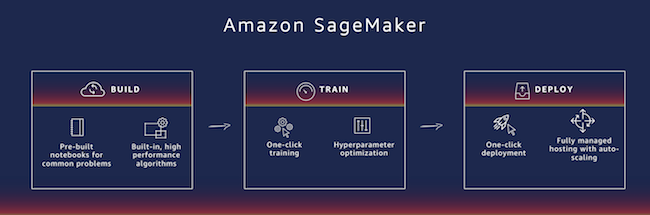

We can typically categorize the task of SageMaker in 3 broad areas -

1. **Build**: Here, we define problem, gather data, analyze it, perform preprocessing to get the data in the desired form.
2. **Train**: We train our model using any machine learning algorithm for the training data made in previous step. Based on the model’s performance, we perform hyperparameter tuning and cross validation to get the best performing model.
3. **Deploy**: We deploy the trained model into production environment where it becomes available to it’s consumers.

It okay if you didn’t understand anything. To make it easier, we will break the entire article into 6 questions and we will be answering each questions with lots of images.

1. **How to create SageMaker Notebook Instance?**
2. **How to create an S3 bucket to store data for training?**
3. **How to build a model in AWS SageMaker Jupyter?**
4. **How to deploy the Model?**
5. **How to invoke trained model endpoint using Lambda Function?**
6. **How to make lambda function available like a REST API using AWS API Gateway?**

## 1. How to create SageMaker Notebook Instance?

SageMaker Notebook instance is like a Jupyter Notebook server where you can manage your virtual environment and all jupyter notebooks just the way you do it in Anaconda.

First, [Login](https://aws.amazon.com/console/) to your AWS account and in the find service tab, search for “Amazon SageMaker”.

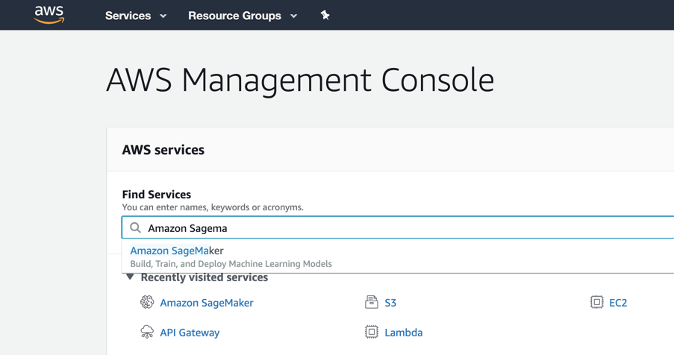

On the Amazon SageMaker homepage, click on “Notebook instances” and then click orange colored “Create notebook instance” button.

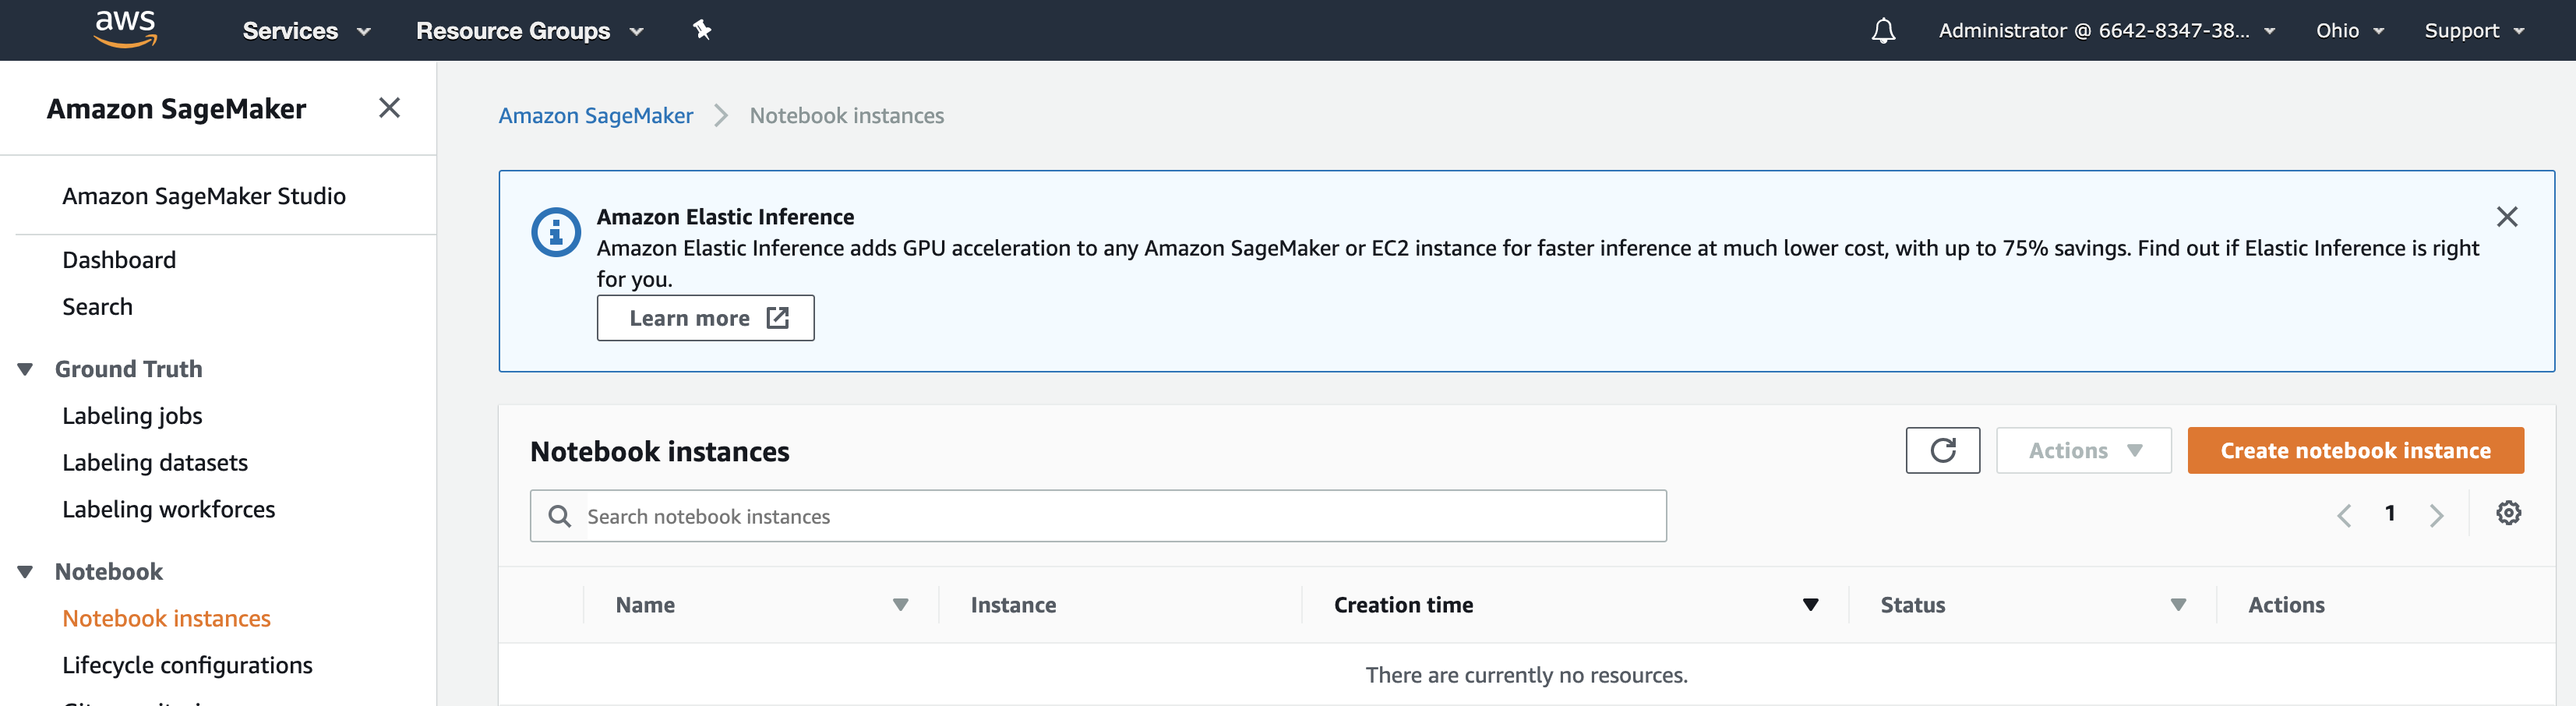

After clicking on “Create notebook instance”, it will open a new page and will ask you to fill the name of Notebook instance. For this exercise, we are naming it to “IR-Spotlight”. The [cost of using SageMaker](https://aws.amazon.com/sagemaker/pricing/) depends on the use as well as type of instance/server used for training. For this exercise, we are using ml.t2.medium instance which comes under free tier limit of AWS. For Elastic Inference, choose none.

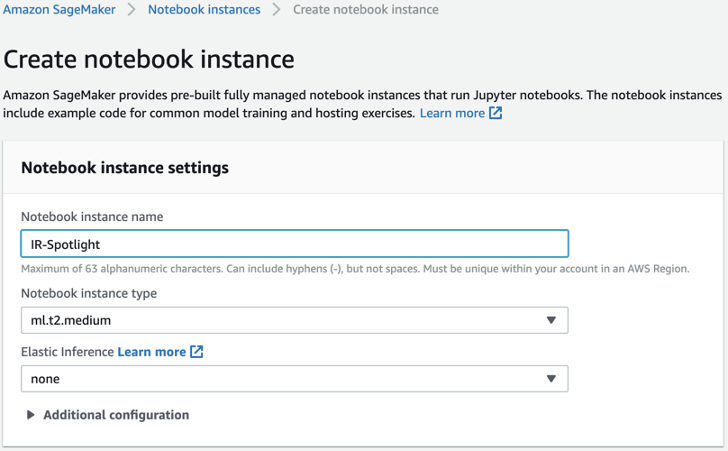

Next, under Permission and encryption box, it will ask you to choose an IAM role for this notebook. [IAM](https://aws.amazon.com/iam/) roles are used to manage access and permission of an AWS resource to another AWS resource. We will be creating a new IAM role by clicking on “Create a new role” option from dropdown.

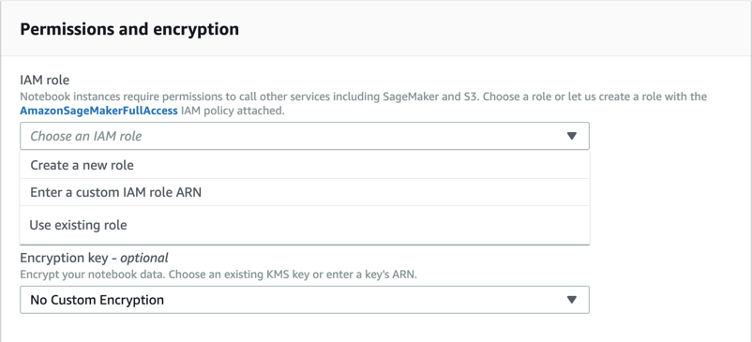

Clicking it will prompt you to a box that will have default values set to full access to S3. Our notebook instance need access to S3 to fetch data for training our Machine Learning Models. Just click on “Create Role” button.

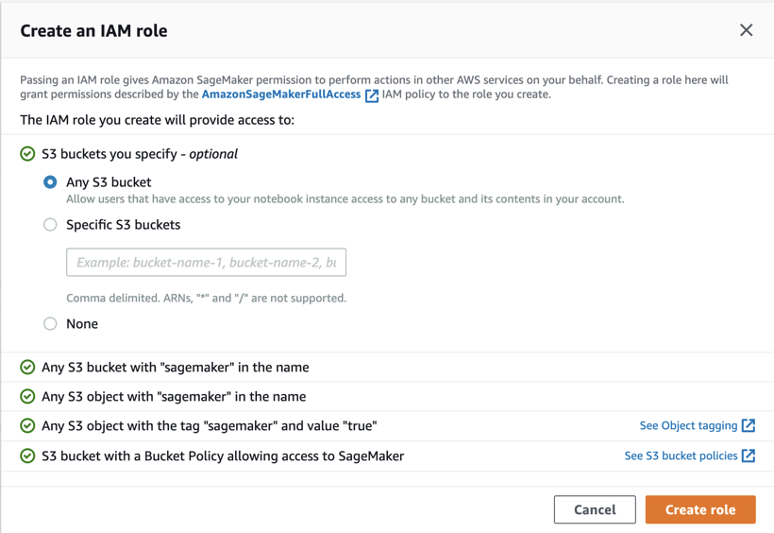

Clicking on “Create Role” button will create a new IAM role which has access to S3. After that, do not modify any other default setting and click on “Create notebook instance”.

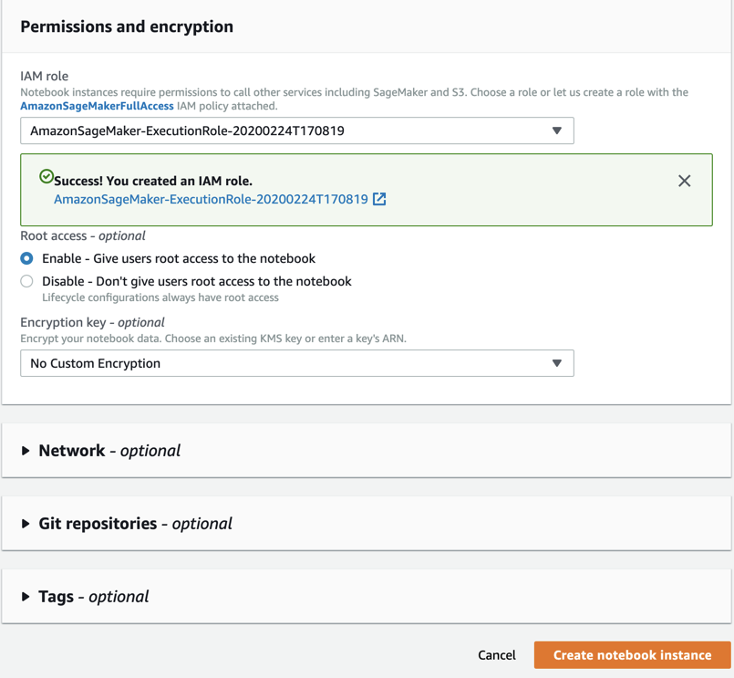

Finally, after all these steps, you will be able to see your Notebook instance. Initially, the status will be “pending” but after some time, it will become “InService” with green tick.

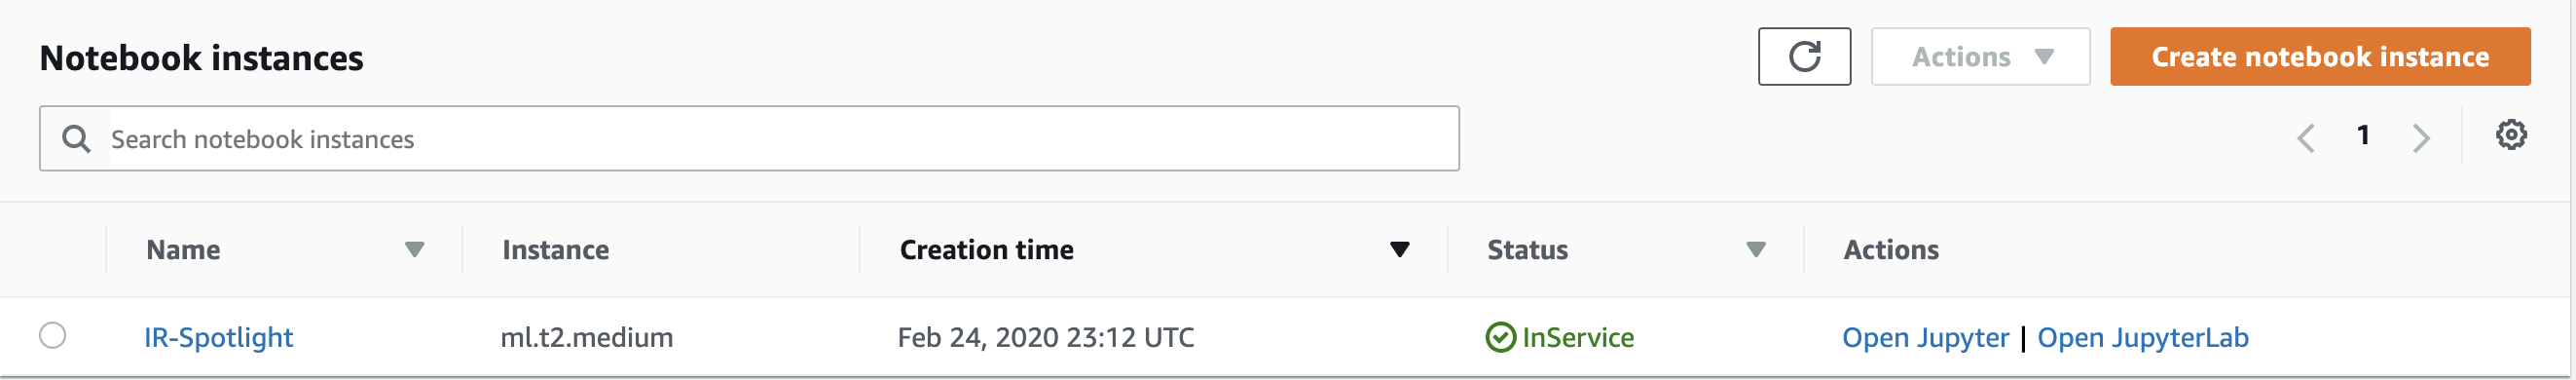

To open your jupyter notebook, just click on the “Open Jupyter”. After this, you will be able to see a regular jupyter like notebook session.

## 1. How to create an S3 bucket to store data for training?

[Amazon S3 or Amazon Simple Storage Service](https://aws.amazon.com/s3/) is a service offered by Amazon Web Services that provides object storage through a web service interface. Amazon S3 uses the same scalable storage infrastructure that Amazon.com uses to run its global e-commerce network.

In the service tab, search for “S3” and then click the S3 option.

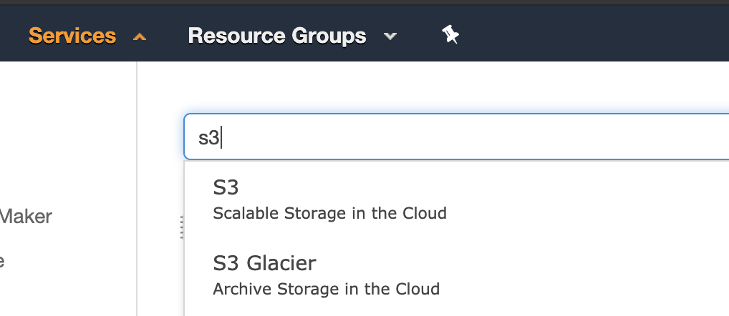

Above action will take you to the Amazon’s S3 homepage. Just click on the “Create bucket” button and enter the bucket name. For this exercise, bucket name is “ir-spotlight-s3-bucket”.

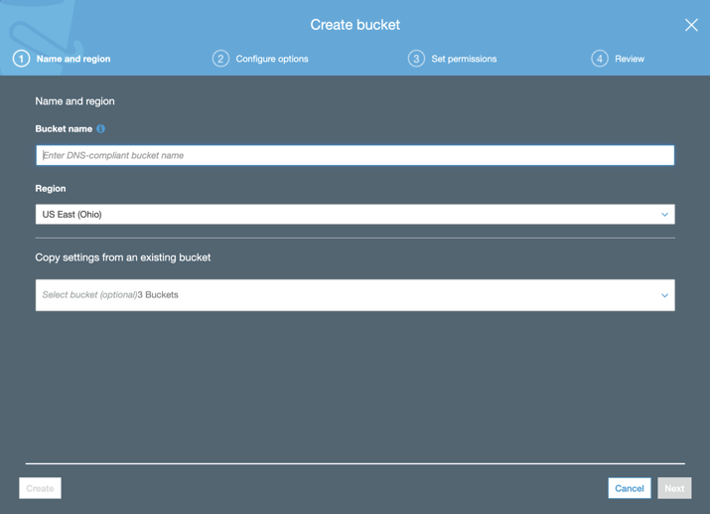

Continue clicking on the “Next” button keeping the default settings for Configure options, Set permissions and finally when you are in Review stage, just click on “Create bucket” button.

After all these steps, you can see your S3 bucket in S3 homepage.

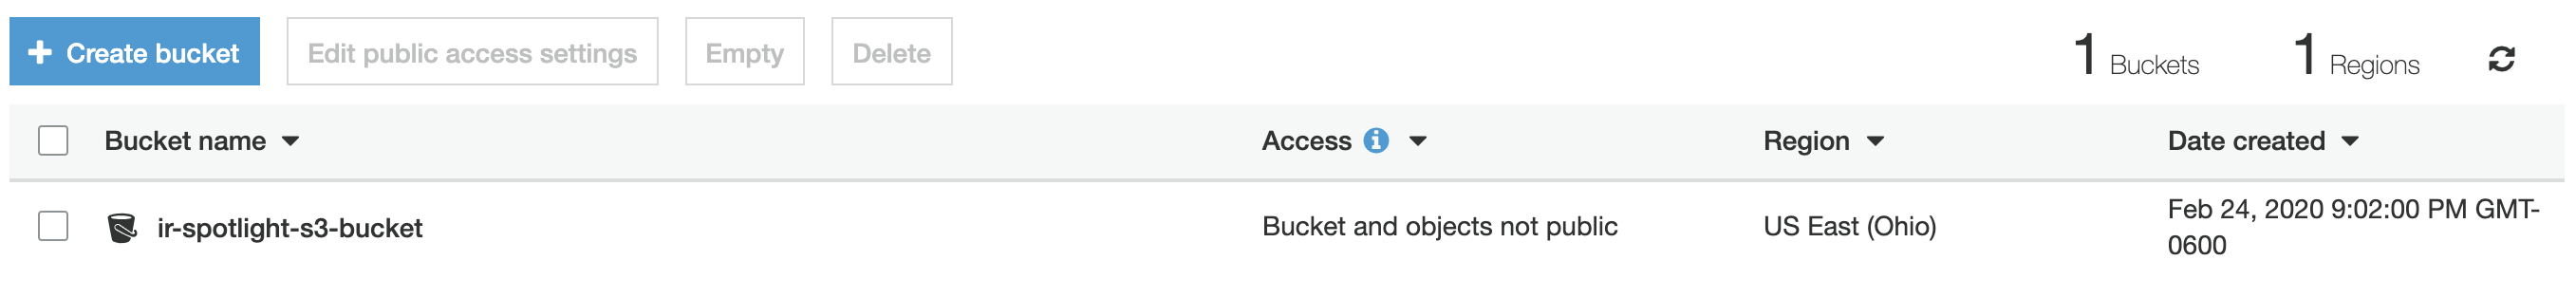

Just take a step back, stretch your arms and relax. Just try to understand what you have achieved till now. You have created your own Jupyter Notebook instance which is using AWS servers (NOT your laptop) and you have also created an S3 bucket where you can dump all your data (NOT your laptop). And the best part, you can sleep peacefully when your model will be training because guess what, AWS never sleeps or shut down or crash like your laptop.

## 3. How to build a model in AWS SageMaker Jupyter?

Once you have created a Jupyter Notebook instance and S3 bucket, next step is to create a Jupyter notebook. Just like your regular jupyter notebook, create a “conda_python3” by clicking on the new button in jupyter notebook and give a name to it. For this exercise, it is named as “IR-Spotlight”.

After this, we start writing code in our Jupyter notebook. As part of this exercise, we will be training a model for digit classification using **MNIST** data and **xgboost** algorithm.

The very first step is to download the data from deeplearning.net

In [ ]:
import pickle
import gzip
import urllib.request
import numpy as np

urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Next, we separate out the training, validation and testing data out of it and dump it in our s3 bucket we created in last step. We are using [boto3](https://aws.amazon.com/sdk-for-python/) here, which is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python, which allows Python developers to write software that makes use of services like Amazon S3 and Amazon EC2.

In [ ]:
import boto3

bucket='ir-spotlight-s3-bucket'

data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]

for data_partition_name, data_partition in data_partitions:
    labels = [t.tolist() for t in data_partition[1]]
    features = [t.tolist() for t in data_partition[0]]
      
    if data_partition_name != 'test':
        examples = np.insert(features, 0, labels, axis=1)
    else:
        examples = features
    np.savetxt('data.csv', examples, delimiter=',')
        
    key = "{}/data".format(data_partition_name)
    boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')

Once the data for training is available in s3, next step is to import Amazon SageMaker Python SDK and get the XGBoost container. SageMaker already contains few known algorithms pre-deployed on the Docker containers in the ECS. All we need is an API to get one for ourselves!

In [ ]:
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role

container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')

Next, we create an instance of the “sagemaker.estimator.Estimator” class and set the hyperparameter values for the XGBoost training job by calling the “set_hyperparameter” method of the estimator.

In [ ]:
train_data = 's3://{}/{}'.format(bucket, 'train')
validation_data = 's3://{}/{}'.format(bucket, 'validation')
s3_output_location = 's3://{}/{}'.format(bucket, 'learn_model_sdk')

xgb_model = sagemaker.estimator.Estimator(container,
                                         get_execution_role(), 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.10xlarge',
                                         train_volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())
xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              silent = 0,
                              objective = "multi:softmax",
                              num_class = 10,
                              num_round = 10)

In the constructor for estimator, you specify the following parameters:

1. **role** – The AWS Identity and Access Management (IAM) role that Amazon SageMaker can assume to perform tasks on your behalf (for example, reading training results, called model artifacts, from the S3 bucket and writing training results to Amazon S3).
2. **train_instance_count** and **train_instance_type** – The type and number of ML compute instances to use for model training. For this exercise, you use only a single training instance.
3. **train_volume_size** – The size, in GB, of the Amazon Elastic Block Store (Amazon EBS) storage volume to attach to the training instance. This must be large enough to store training data if you use File mode (File mode is the default).
4. **output_path** – The path to the S3 bucket where Amazon SageMaker stores the training results.
5. **sagemaker_session** – The session object that manages interactions with Amazon SageMaker APIs and any other AWS service that the training job uses.

Next, we create data channels to access data from S3 to SageMaker. We create the data channels for both, training and validation set. Data channels holds a reference to all the data we need for training our model and reduce the RAM overhead.

In [ ]:
train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
valid_channel = sagemaker.session.s3_input(validation_data, content_type='text/csv')
data_channels = {'train': train_channel, 'validation': valid_channel}

xgb_model.fit(inputs=data_channels,  logs=True)

Finally, we fit our model xgb_model.fit() which also generates logs if we set logs=True.

## 4. How to deploy the Model?

Once the model is fit, deploying the model is just a single function call away. You can deploy your model by adding below code.

In [ ]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                instance_type='ml.m4.xlarge',
                                )

Once all of the above code is executed, we can see the entire instances, jobs and models created in the SageMaker Dashboard.

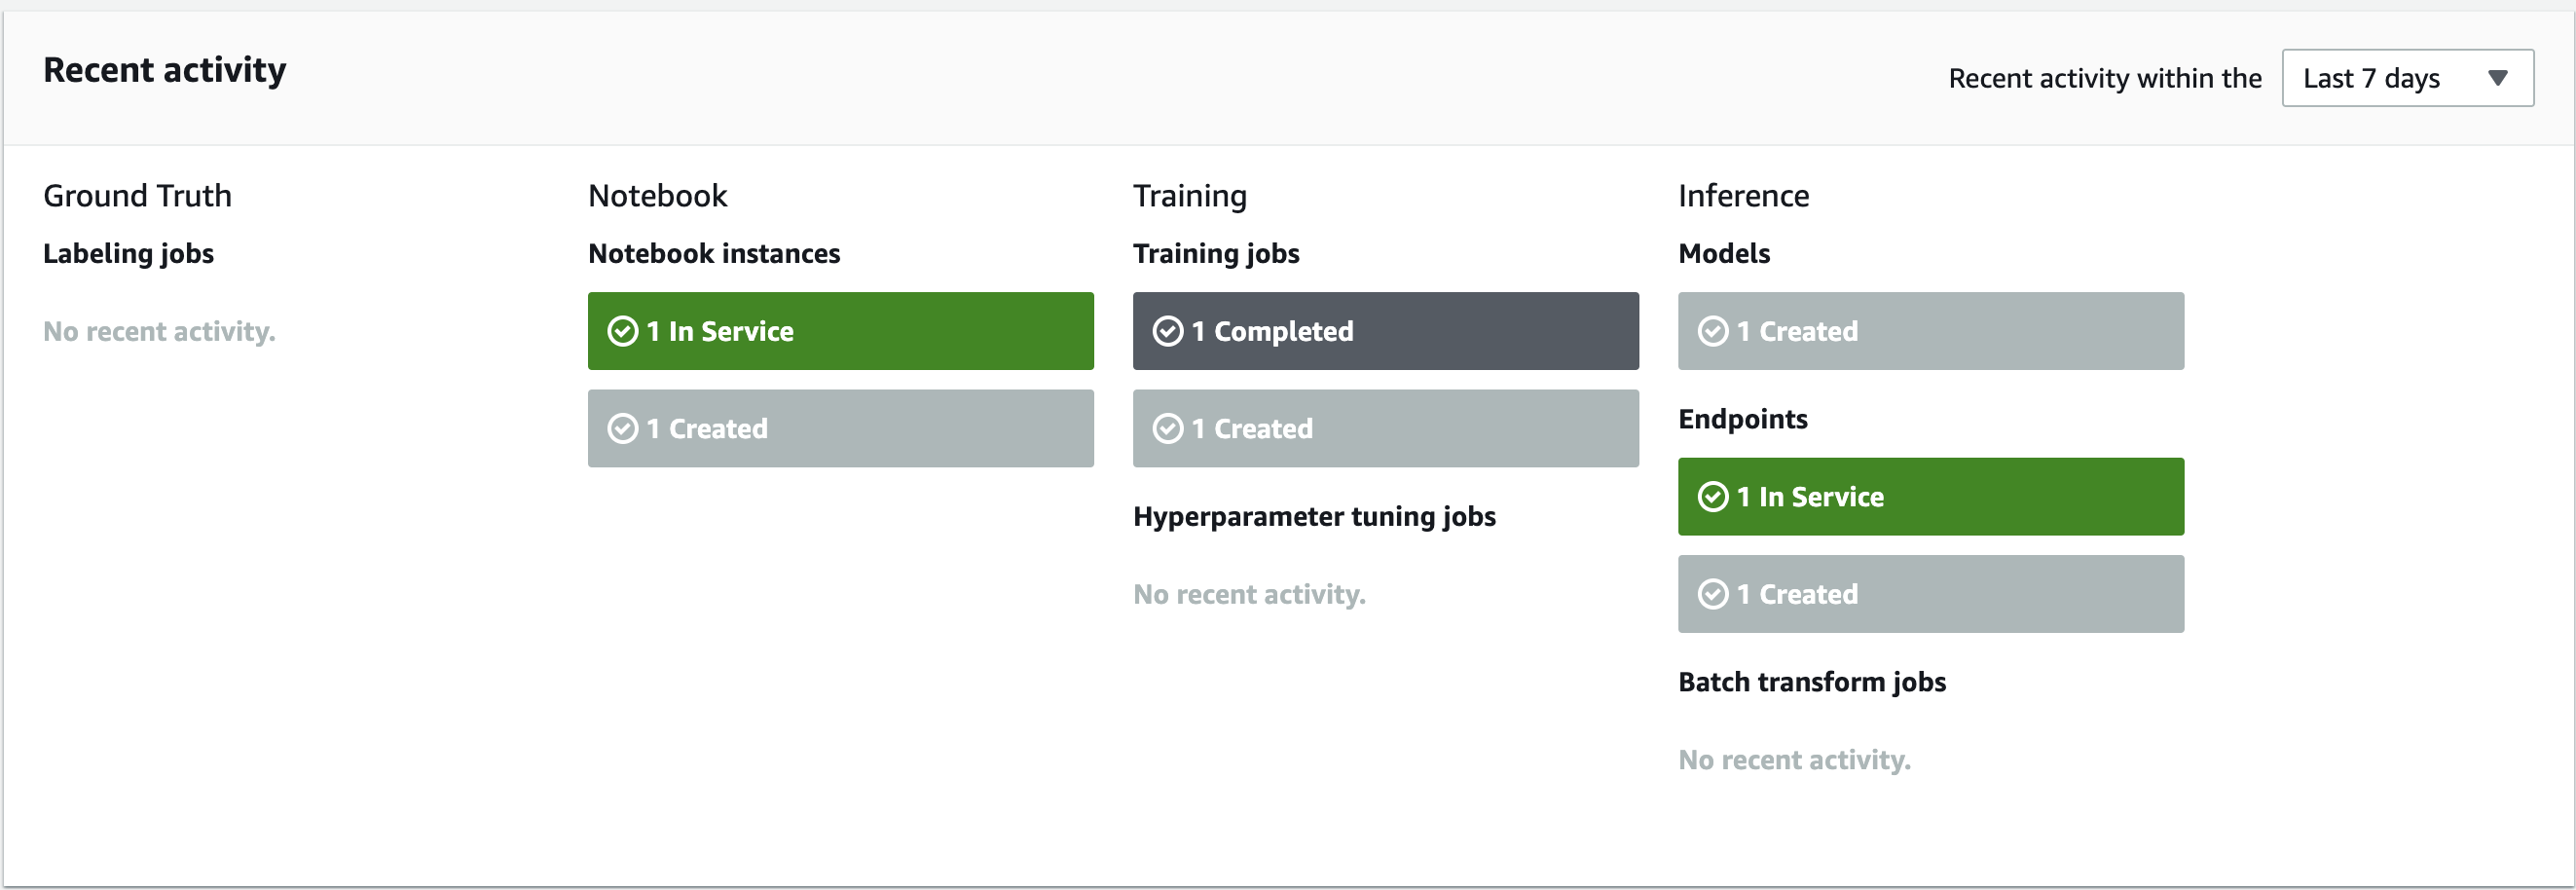

If you click on Models 1 Created, you can see all your models created as part of previous exercise and if you click on Endpoints 1 in Service, you can see you endpoint ready for you which can be invoked using lambda function.

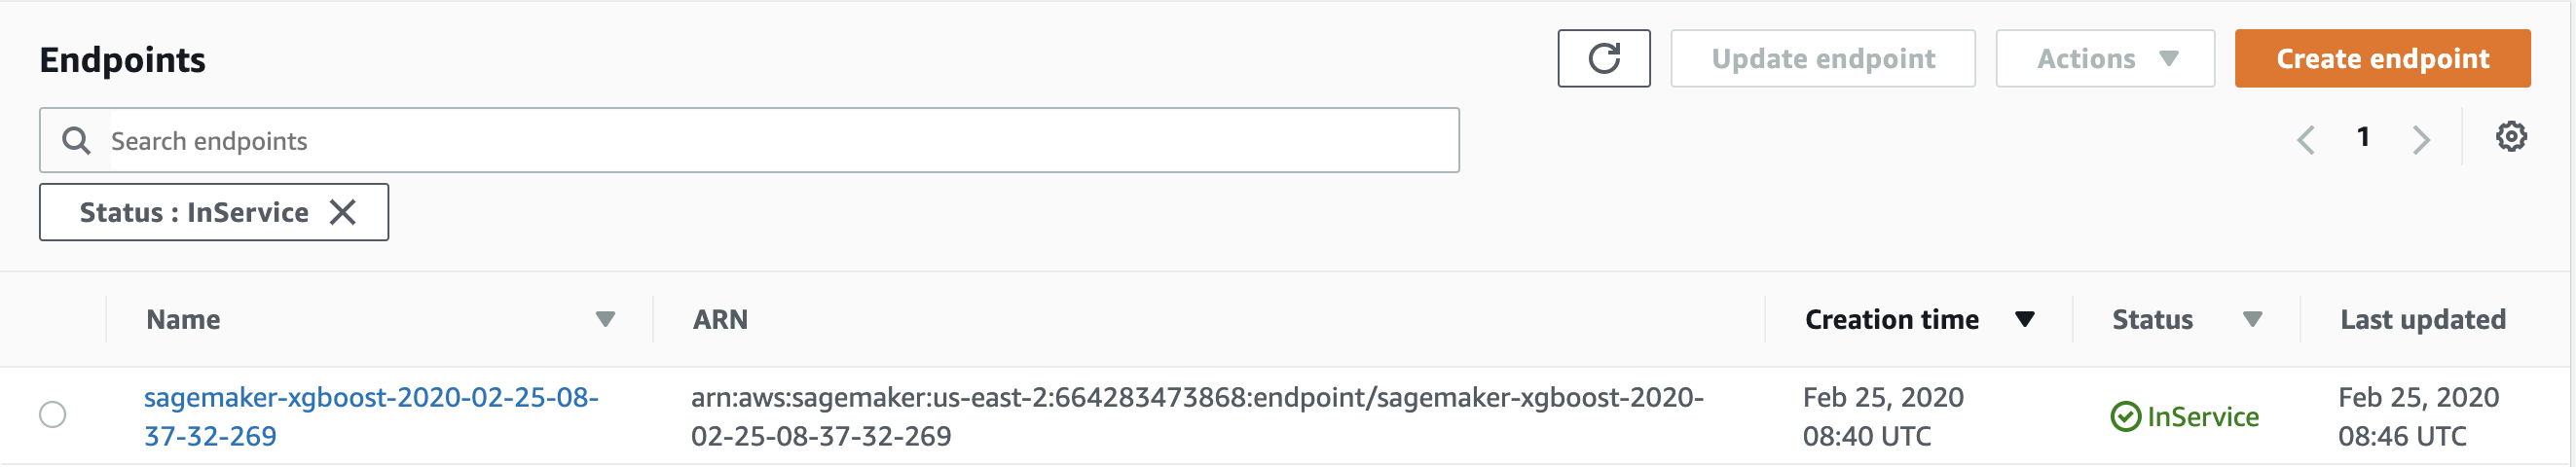

Let’s understand what we have done till now.

We will say Good Bye to SageMaker here. We wrote a code in jupyter notebook which downloads data and save it in S3. Then it uses the data in S3 to train our model and once the model is finally trained, we deploy the model using a very simple one line code. Now our model if available to use using the endpoint we created in last step.

## 5. How to invoke trained model endpoint using Lambda Function?

AWS Lambda is an event-driven, serverless computing platform provided by Amazon as part of Amazon Web Services. It is a computing service that runs code in response to events and automatically manages the computing resources required by that code.

Go to service tab and search for “Lambda” there and click it.

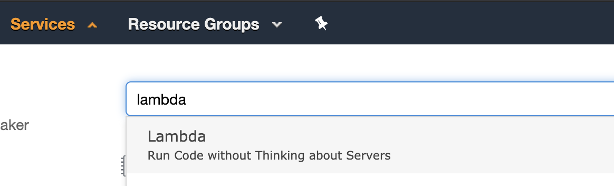

Click on “Create Function” which will bring you to a page which will give you multiple options to create a lambda function.

Choose “Author from scratch”, name your lambda as “IR-Spotlight-SageMaker-Lambda” and choose “Python 3.7” as your runtime language option and click on “Create function”.

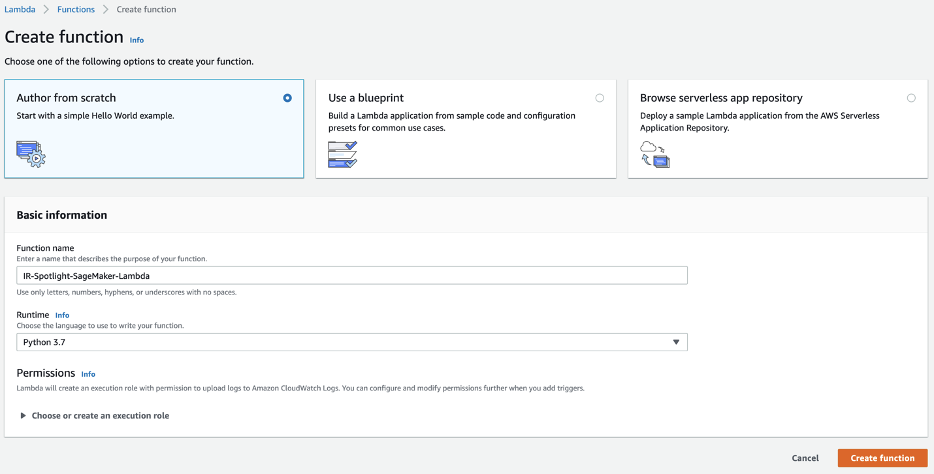

Once you hit “Create function” you lambda function is created in few seconds.

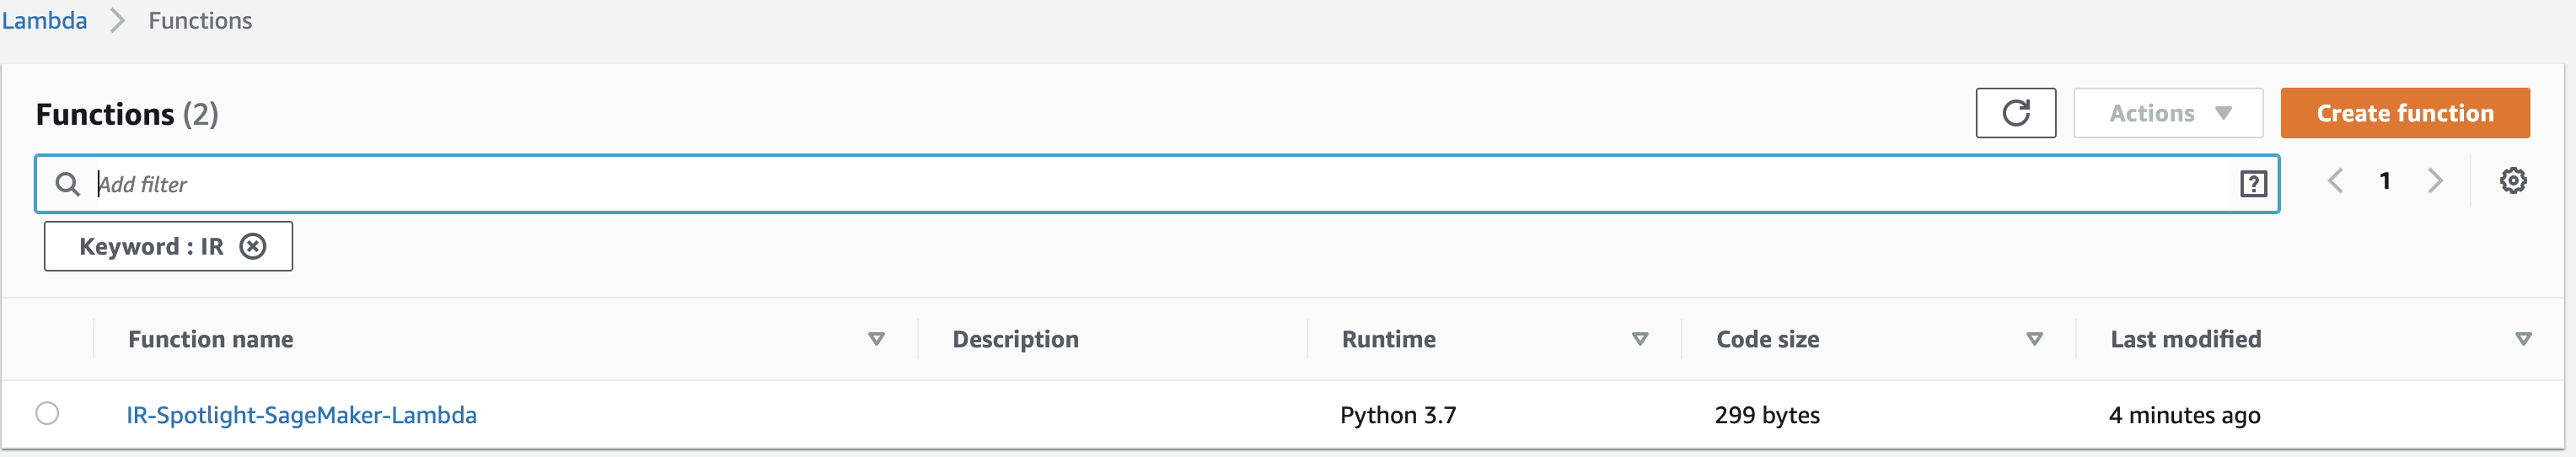

Click on your function name to view the function and an inbuilt code editor to write your lambda code.

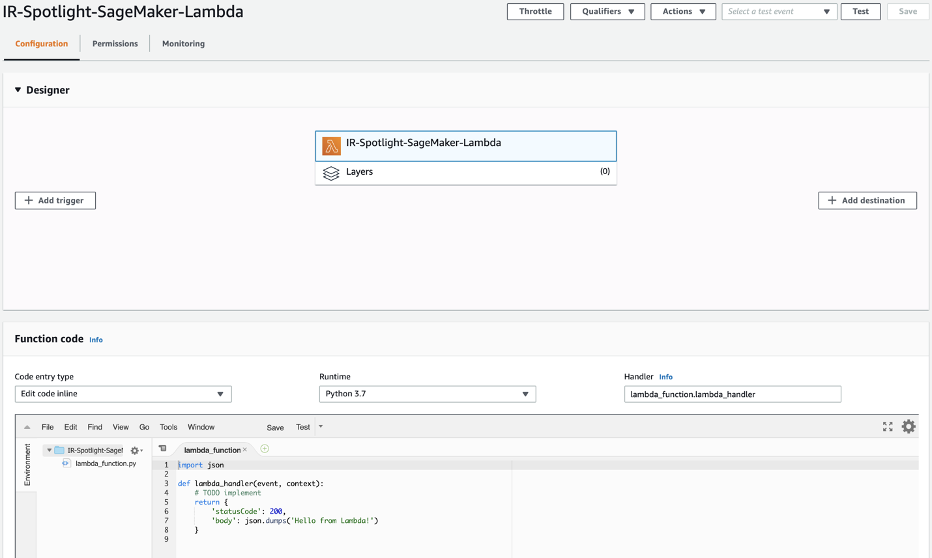

Next, you want it to have access to few functions of SageMaker to invoke the endpoint. To do that, you will have to add few policies in the default IAM role created for this lambda function.

Scroll down on the same page below the code editor to find the **Execution role** box and below Existing role, click on “View the your-default-IAM-role-name”.

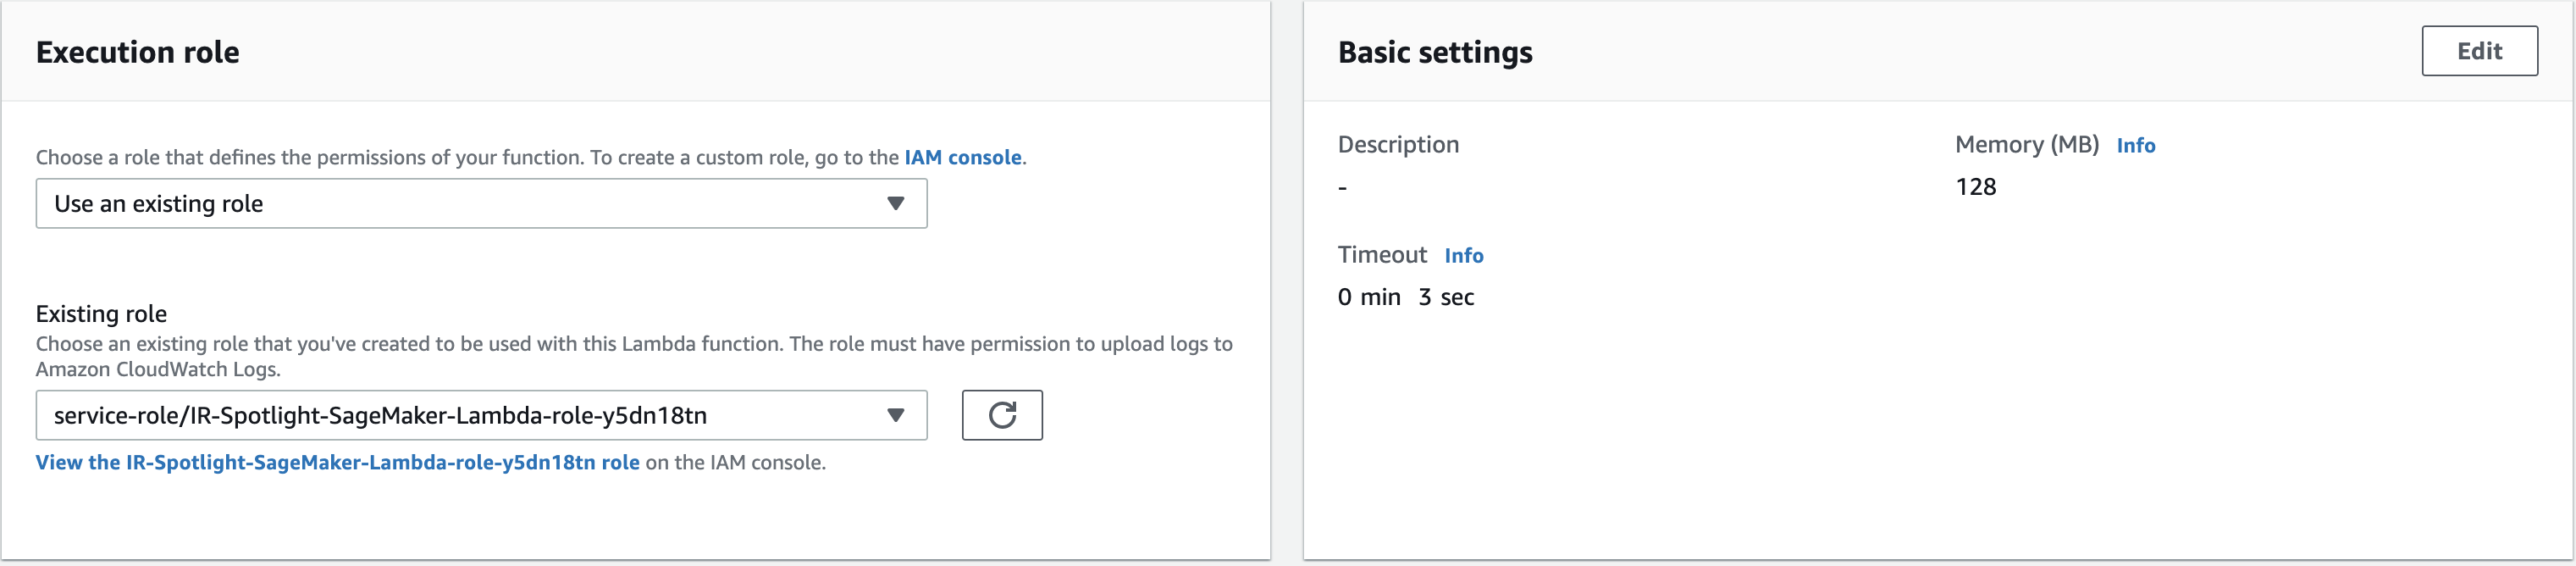

Once you click it, you will get redirected to the IAM Management console. On that page, click on “AWSLambdaBasicExecutionRole-some-random-number” to view the permissions granted to this role.

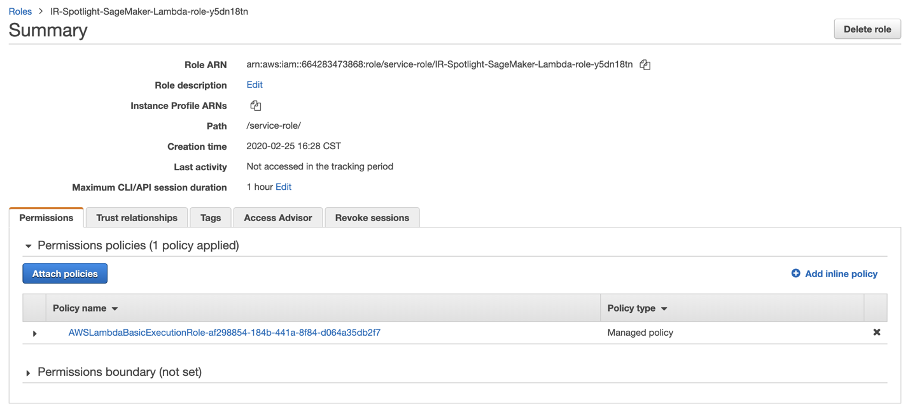

After clicking it, you can see the default permission/policy tied to this role. By default, a lambda is granted the permission to write logs.

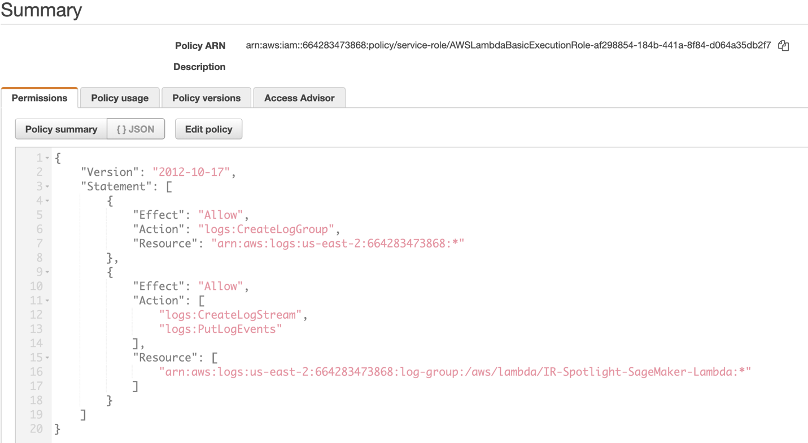

Click on “Edit policy” to add extra permissions to this IAM role. After that, click “Add additional permissions” which will bring a big drop down to choose service and what permission to add over that service.

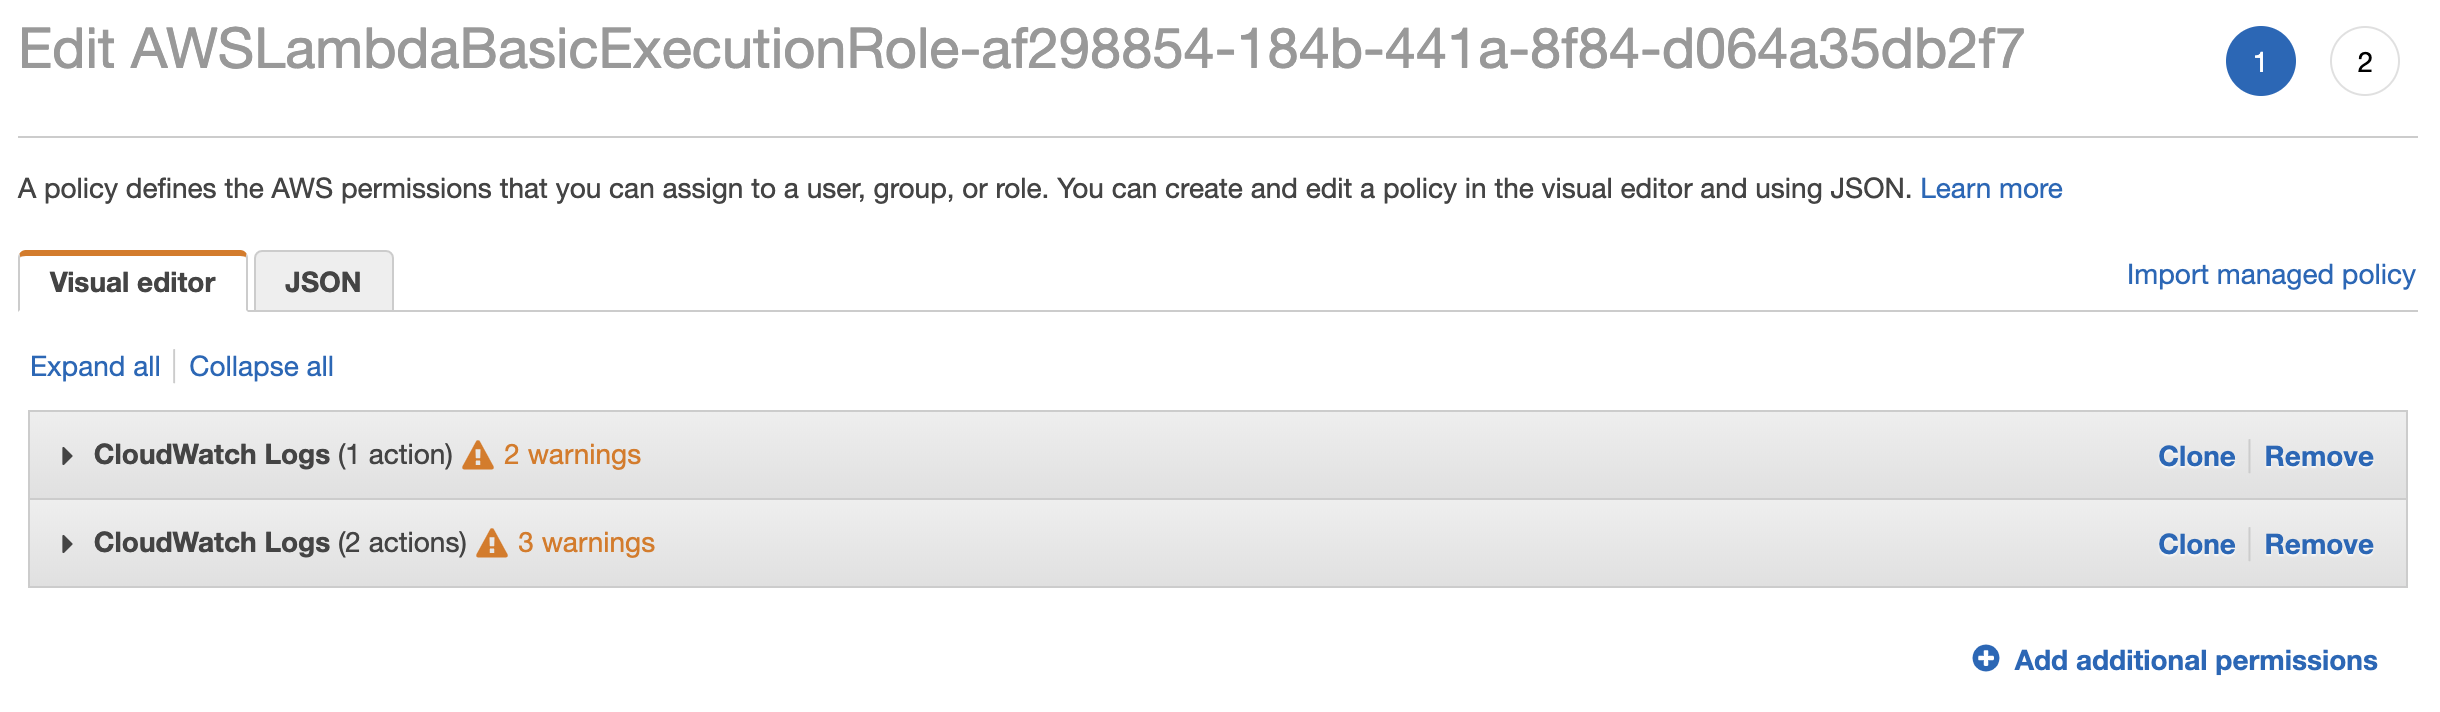

After clicking it, choose “SageMaker” as service, “InvokeEndpoint” as action under Read option and click on “All Resources” radio button in Resource section. Finally, click on “Review policy” and then “Save changes” to add new permissions in your IAM role.

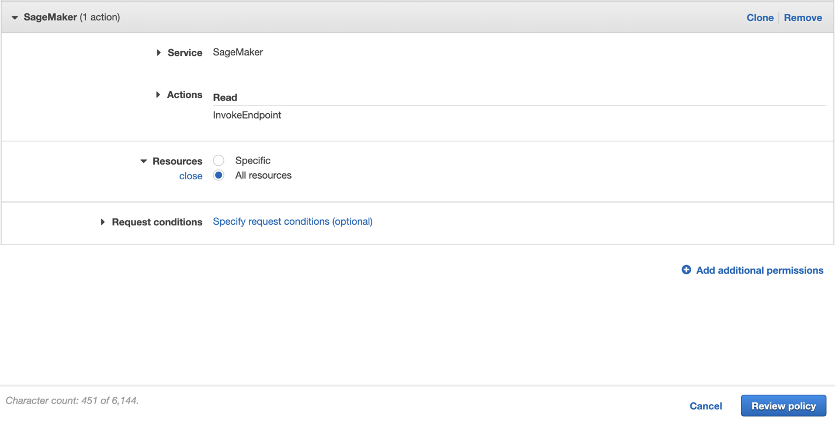

Once this is done, go back to your lambda function and start writing your lambda function to invoke the endpoint from there.

Following code is the implementation of a lambda function that invokes an endpoint in SageMaker.

In [ ]:
import boto3
import json

ENDPOINT_NAME = "sagemaker-xgboost-2020-02-25-08-37-32-269"
sagemaker_client = boto3.client('runtime.sagemaker')

def lambda_handler(event, context):
    data = json.loads(json.dumps(event))
    image_data = data['data']

    response = sagemaker_client.invoke_endpoint(EndpointName = ENDPOINT_NAME,
                                              ContentType = 'text/csv',
                                              Body = image_data)
                                              
    result = response['Body'].read().decode('ascii')
  
    return {
        "statusCode": 200,
        "body": json.dumps('Predicted label is {}.'.format(result))
    }

ENDPOINT_NAME is the name of your model endpoint that you created previously and you can use sagemaker client created using boto3 to call the model endpoint.

To Test your lambda function, click on Test button and it will ask you to configure a test. Just click on it and create a test case by creating a json like below.

In [ ]:
{
  "data": "0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,3.281250000000000000e-01,7.226562500000000000e-01,6.210937500000000000e-01,5.898437500000000000e-01,2.343750000000000000e-01,1.406250000000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,8.671875000000000000e-01,9.921875000000000000e-01,9.921875000000000000e-01,9.921875000000000000e-01,9.921875000000000000e-01,9.414062500000000000e-01,7.734375000000000000e-01,7.734375000000000000e-01,7.734375000000000000e-01,7.734375000000000000e-01,7.734375000000000000e-01,7.734375000000000000e-01,7.734375000000000000e-01,7.734375000000000000e-01,6.640625000000000000e-01,2.031250000000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,2.617187500000000000e-01,4.453125000000000000e-01,2.812500000000000000e-01,4.453125000000000000e-01,6.367187500000000000e-01,8.867187500000000000e-01,9.921875000000000000e-01,8.789062500000000000e-01,9.921875000000000000e-01,9.921875000000000000e-01,9.921875000000000000e-01,9.765625000000000000e-01,8.945312500000000000e-01,9.921875000000000000e-01,9.921875000000000000e-01,5.468750000000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,6.640625000000000000e-02,2.578125000000000000e-01,5.468750000000000000e-02,2.617187500000000000e-01,2.617187500000000000e-01,2.617187500000000000e-01,2.304687500000000000e-01,8.203125000000000000e-02,9.218750000000000000e-01,9.921875000000000000e-01,4.140625000000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,3.242187500000000000e-01,9.882812500000000000e-01,8.164062500000000000e-01,7.031250000000000000e-02,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,8.593750000000000000e-02,9.101562500000000000e-01,9.960937500000000000e-01,3.242187500000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,5.039062500000000000e-01,9.921875000000000000e-01,9.296875000000000000e-01,1.718750000000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,2.304687500000000000e-01,9.726562500000000000e-01,9.921875000000000000e-01,2.421875000000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,5.195312500000000000e-01,9.921875000000000000e-01,7.304687500000000000e-01,1.953125000000000000e-02,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,3.515625000000000000e-02,8.007812500000000000e-01,9.687500000000000000e-01,2.265625000000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,4.921875000000000000e-01,9.921875000000000000e-01,7.109375000000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,2.929687500000000000e-01,9.804687500000000000e-01,9.375000000000000000e-01,2.226562500000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,7.421875000000000000e-02,8.632812500000000000e-01,9.921875000000000000e-01,6.484375000000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,1.171875000000000000e-02,7.929687500000000000e-01,9.921875000000000000e-01,8.554687500000000000e-01,1.367187500000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,1.484375000000000000e-01,9.921875000000000000e-01,9.921875000000000000e-01,3.007812500000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,1.210937500000000000e-01,8.750000000000000000e-01,9.921875000000000000e-01,4.492187500000000000e-01,3.906250000000000000e-03,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,5.195312500000000000e-01,9.921875000000000000e-01,9.921875000000000000e-01,2.031250000000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,2.382812500000000000e-01,9.453125000000000000e-01,9.921875000000000000e-01,9.921875000000000000e-01,2.031250000000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,4.726562500000000000e-01,9.921875000000000000e-01,9.921875000000000000e-01,8.554687500000000000e-01,1.562500000000000000e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,4.726562500000000000e-01,9.921875000000000000e-01,8.085937500000000000e-01,7.031250000000000000e-02,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00"
}

Once the test is configured, just hit the test again and below the code editor in the console, you can see the output of your lambda function.

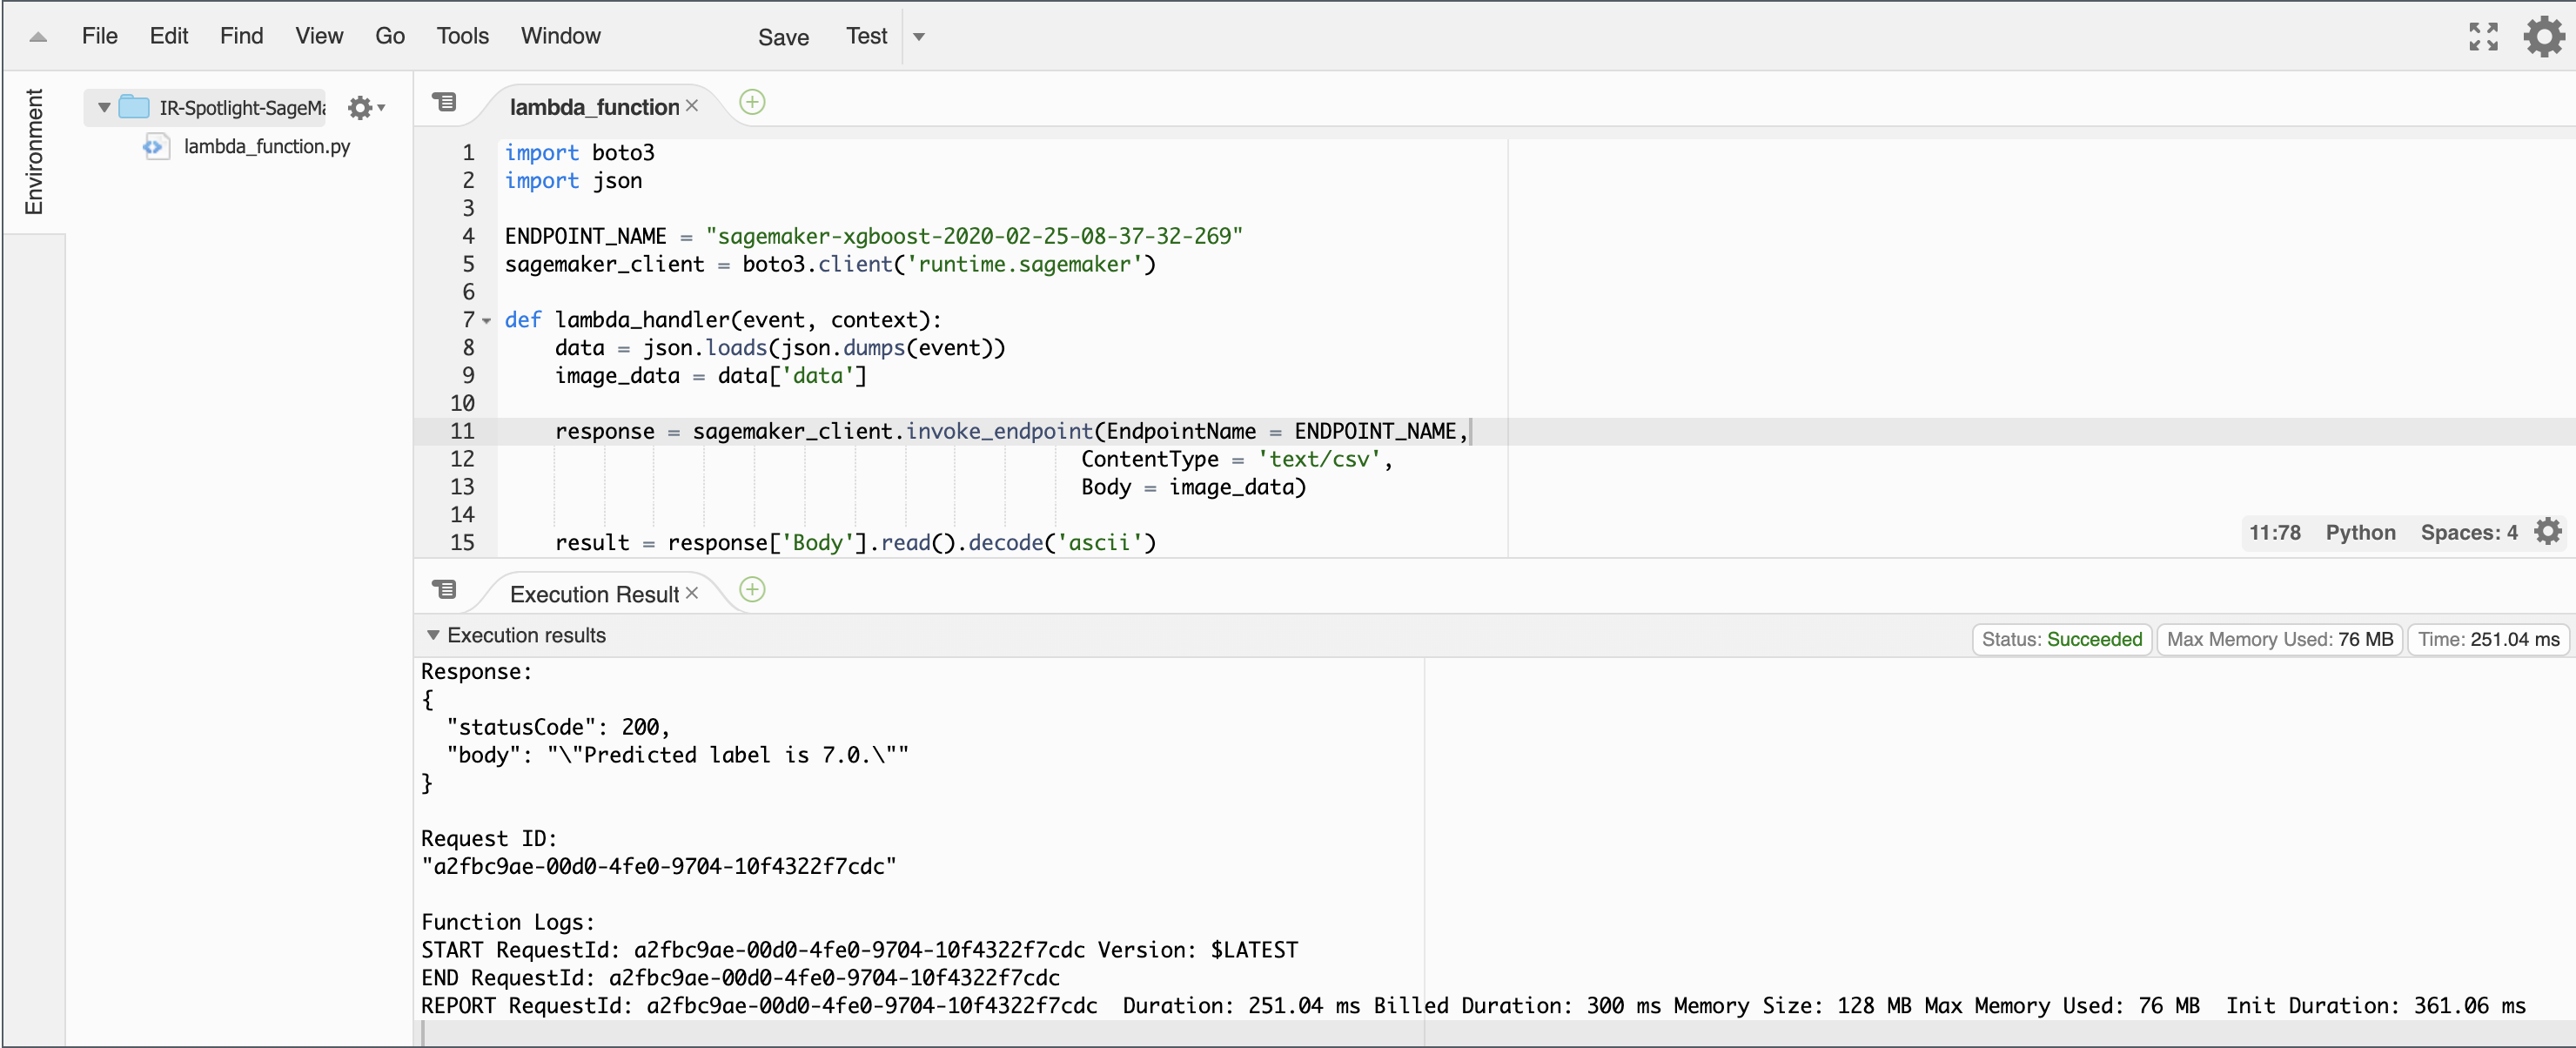

## 6. How to make lambda function available like a REST API using AWS API Gateway?

Amazon API Gateway is a fully managed service that makes it easy for developers to create, publish, maintain, monitor, and secure APIs at any scale. APIs act as the “front door” for applications to access data, business logic, or functionality from your backend services. Using API Gateway, you can create RESTful APIs and WebSocket APIs that enable real-time two-way communication applications.

Go to service tag and search for “API Gateway” and click it.

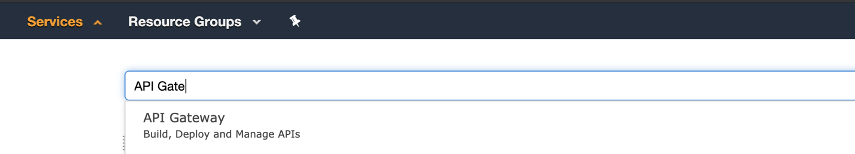

On the API Gateway homepage, click on Create API. Then, in the page to choose the API type, click on “Build” for REST API.

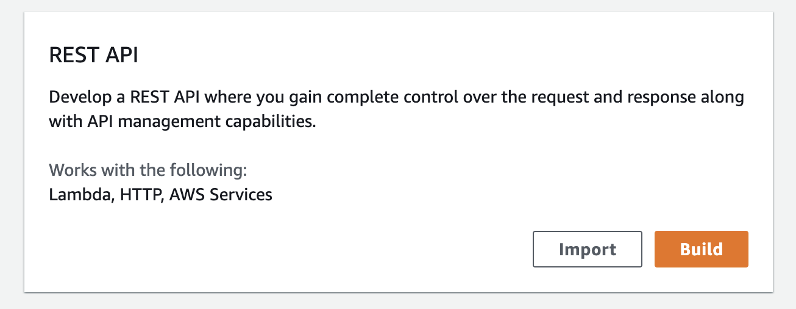

In the next page, keep the default options as it is and just enter the API name that you want to give and click on “Create API”. For this exercise, it is “IR-Spotlight-Lambda-API”.

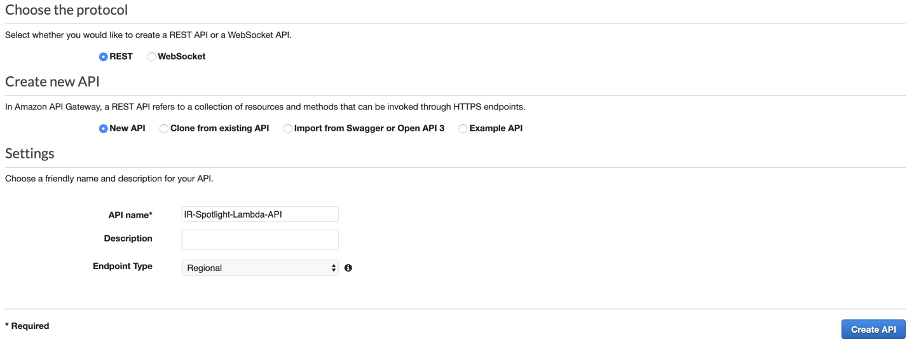

Once the API is created, then in the API page, click on “Actions” button and in the dropdown, click on “Create Resource”. Resource is like a sub-API over the main API that contains https methods.

For this exercise, name the resource as predict-digit because we want to use this API to predict digits from given pixel matrix.

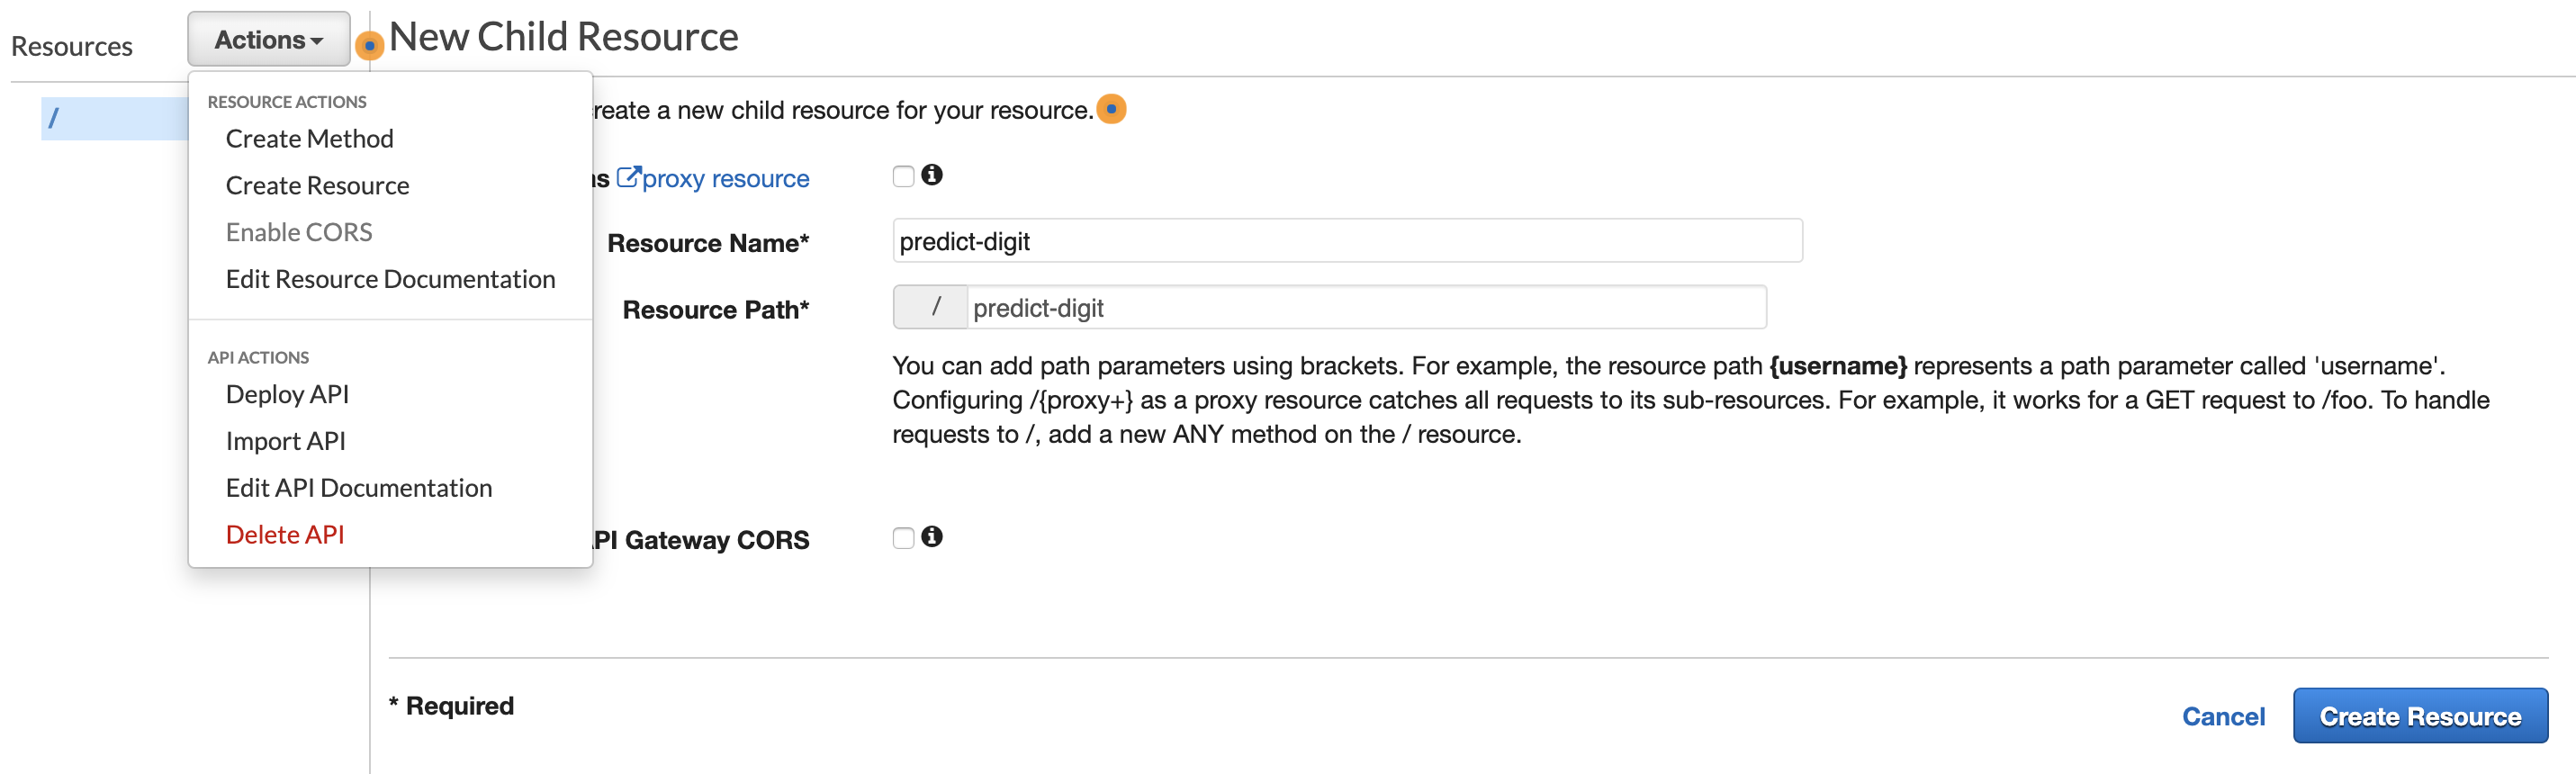

Once the resource is created, next step is to create a method. Ideally, for this purpose, we should create a GET API but since our request is very big, so we will create a POST API and in the request body, we can send the image matrix.

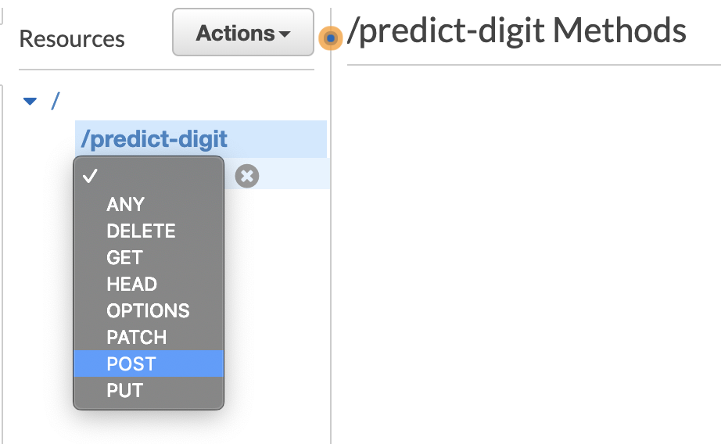

After choosing POST from the dropdown below the resource name, click on small tick mark to the left of cross mark.

After this, to the right side, enter the name of your lambda function and click on “Save” and then “Ok”.

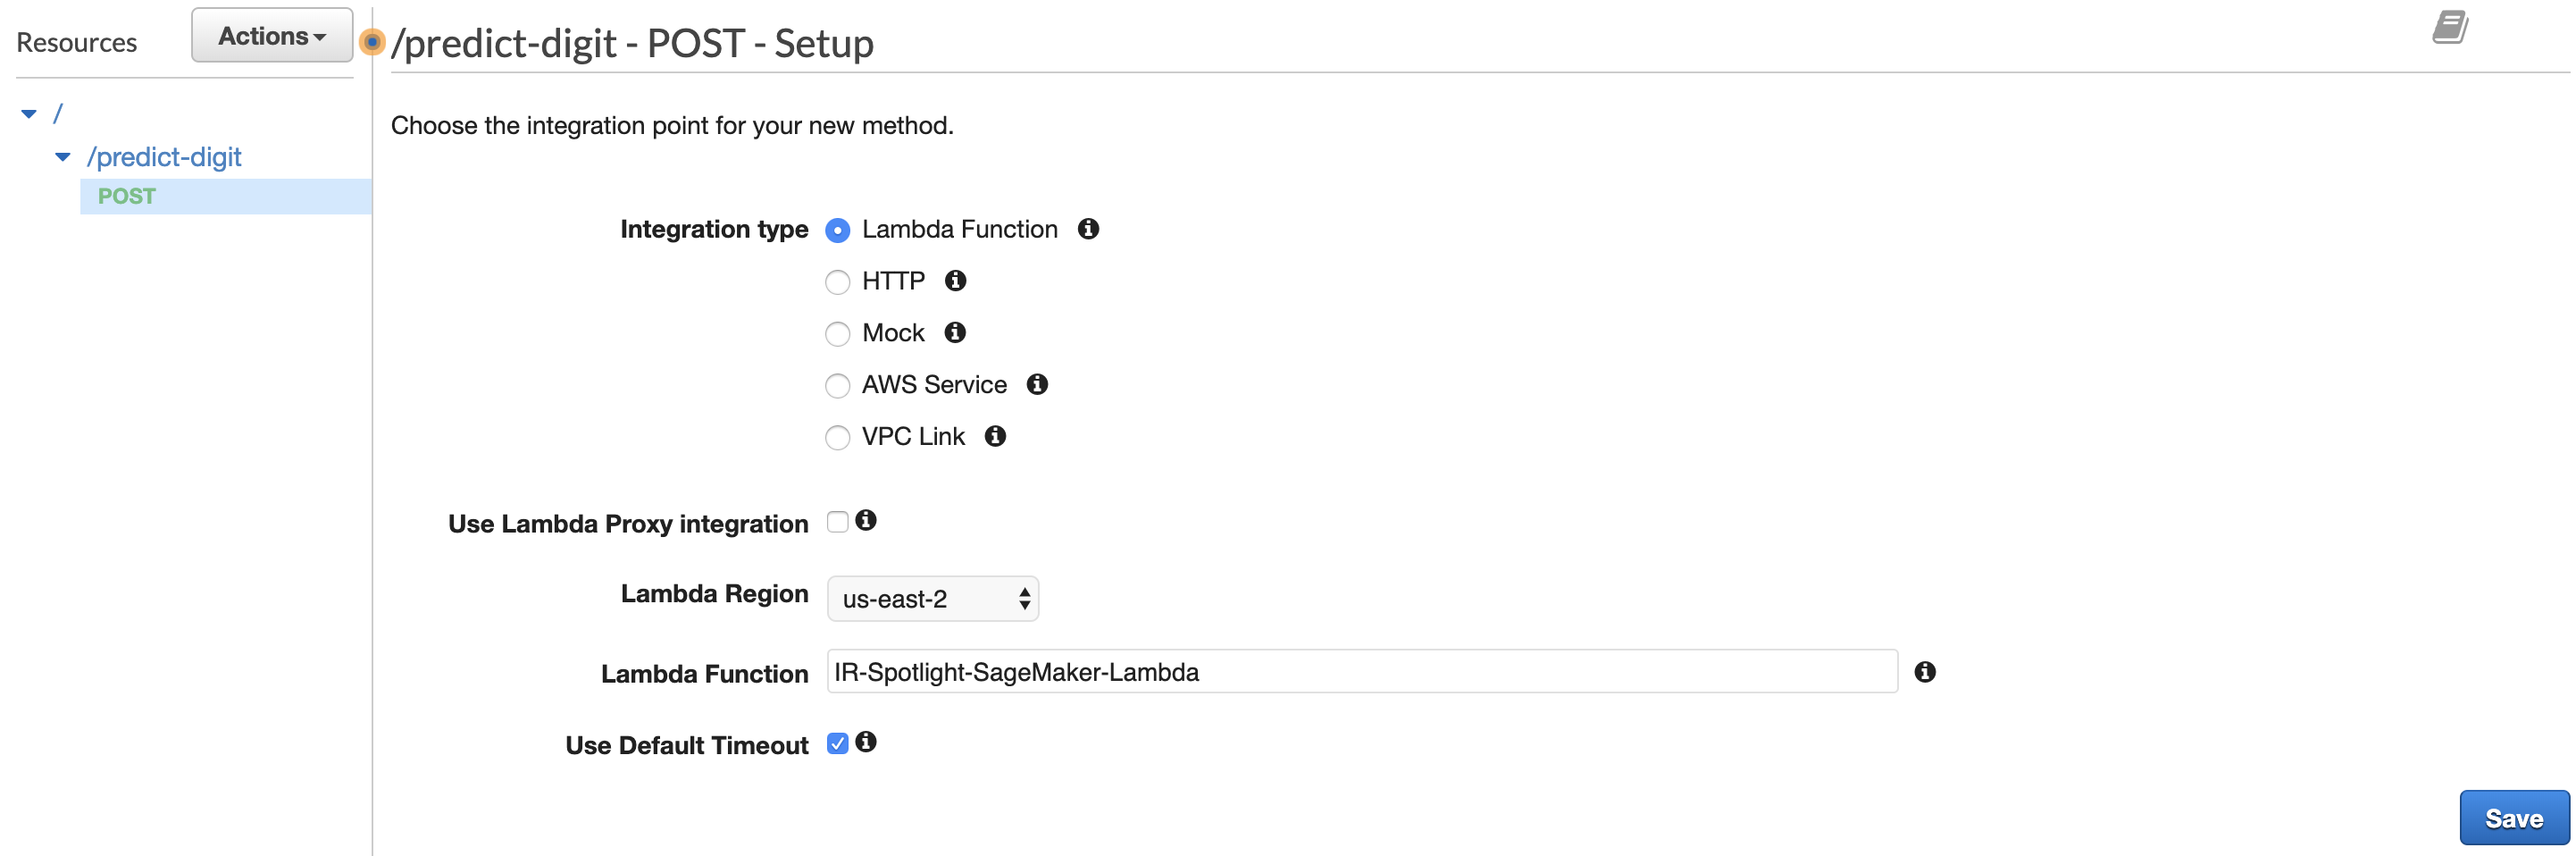

After all these steps, you can see your method and the entire flow of how it is interacting with your lambda.

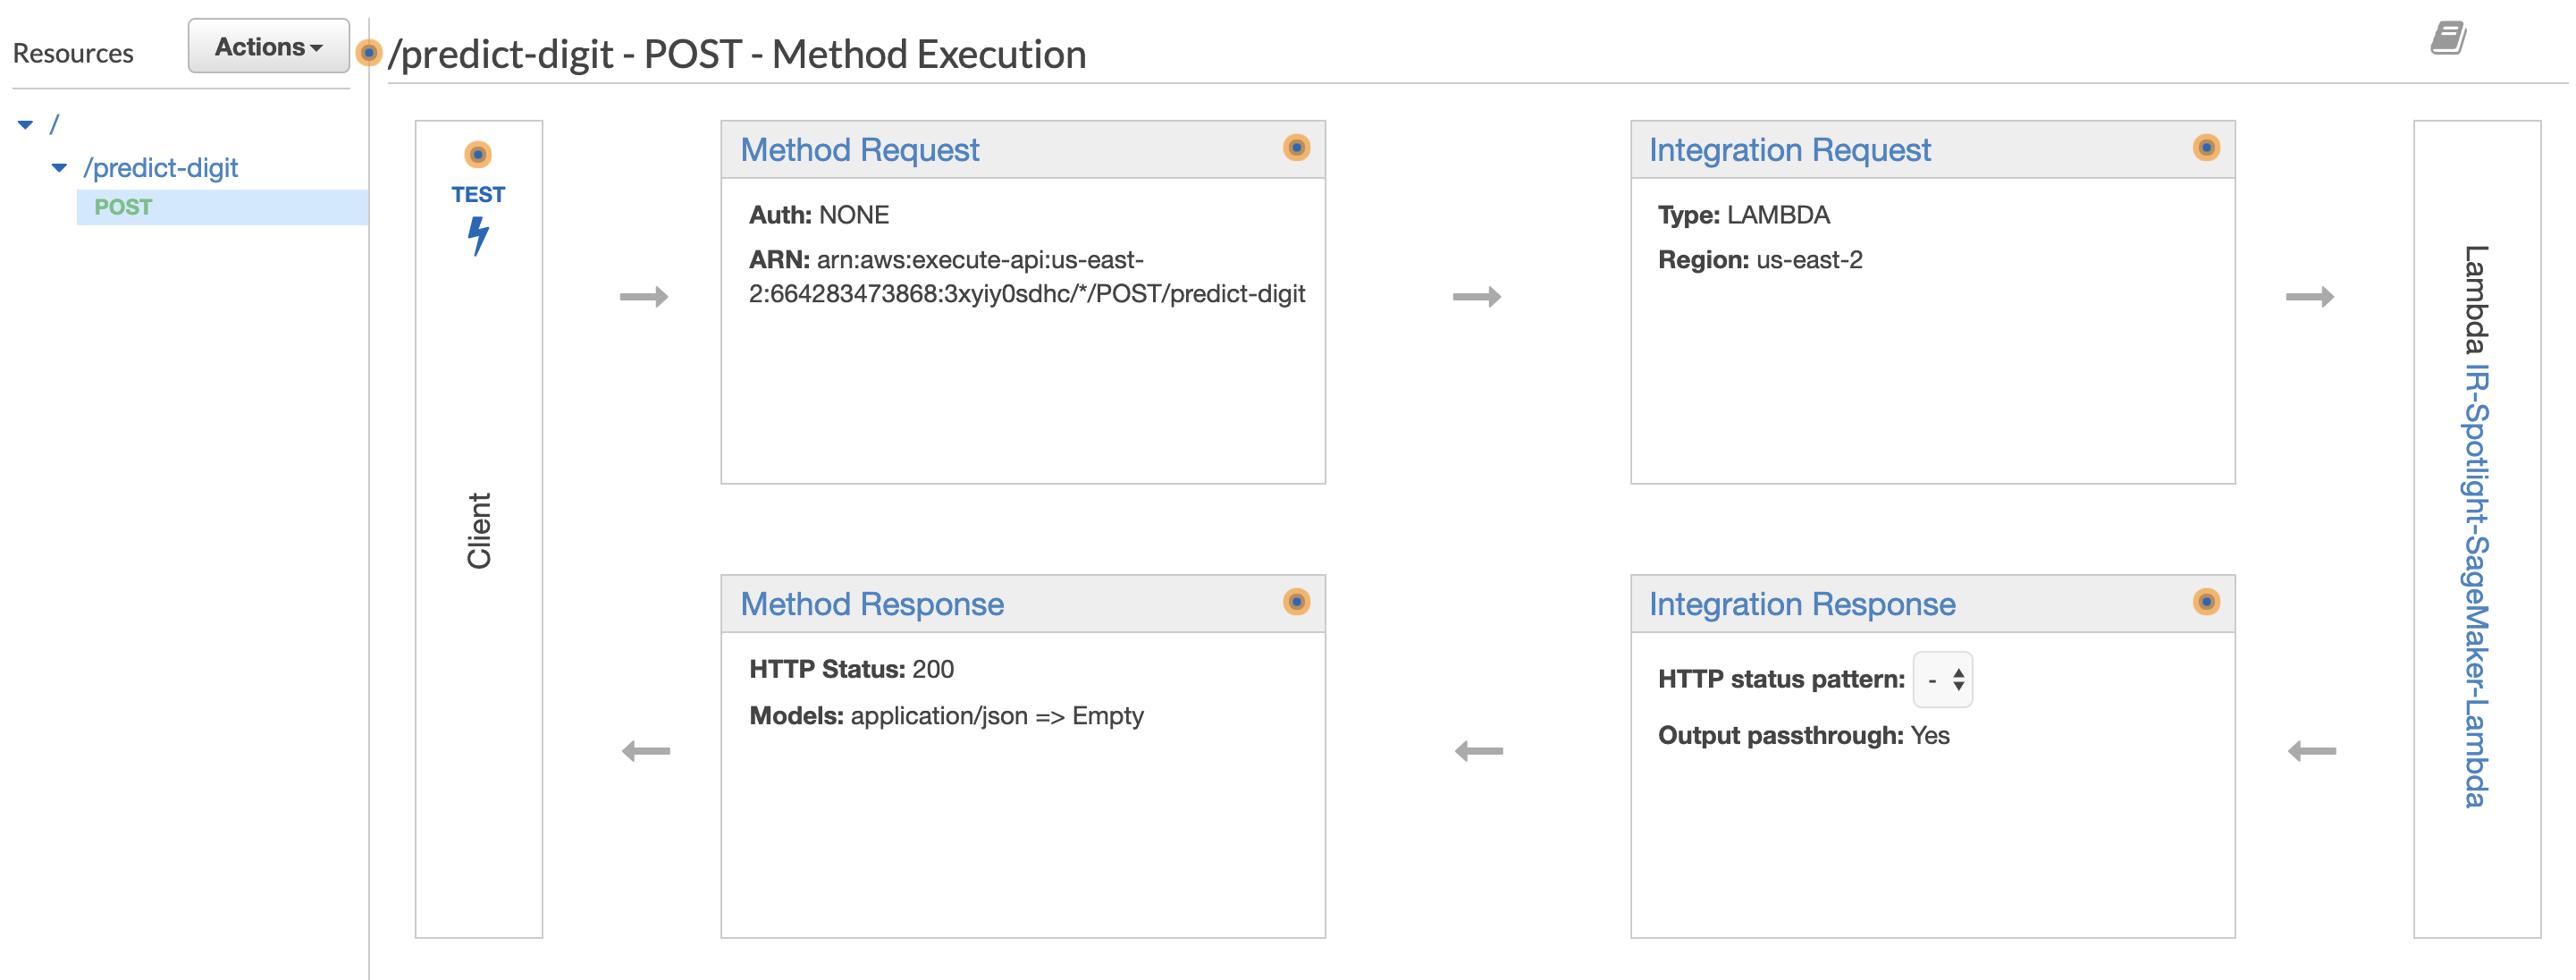

Now to test if your API is well integrated with your lambda, click on Test. Scroll down and in the “Request Body”, put your input in json format like below and hit “Test”.

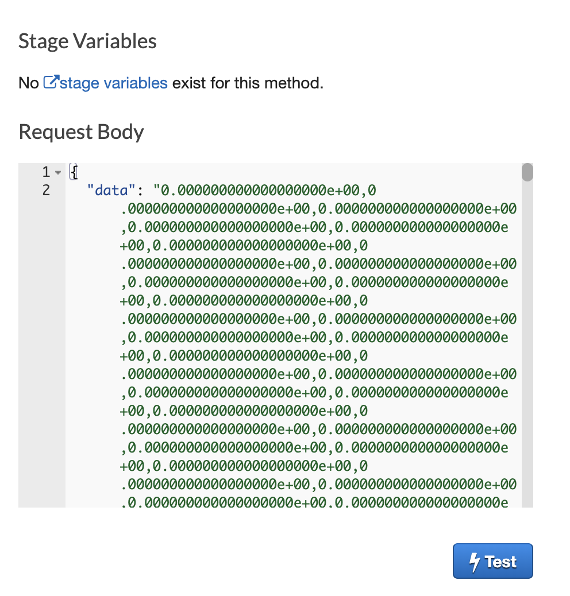

If your API is well integrated with your lambda, then in the right side of the page, you will see the response of your API call.

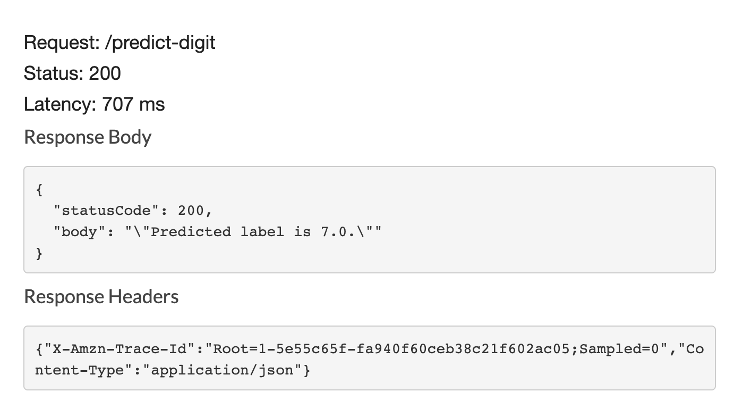

If you see some error, the go to cloudwatch to look at the logs and debug the issue.

Now one and final step is to make this API available to the consumers. To do this, click on “Actions” again and choose “Deploy API” from the dropdown.

In the pop-up, create a new deployment stage, name it “Prod” and then click on “Deploy”.

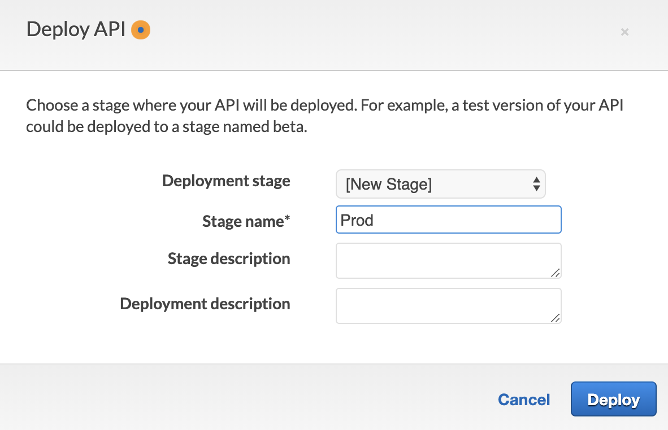

Once the API is deployed in production, you will get redirected to the “Stages” page where you can see your API production url.

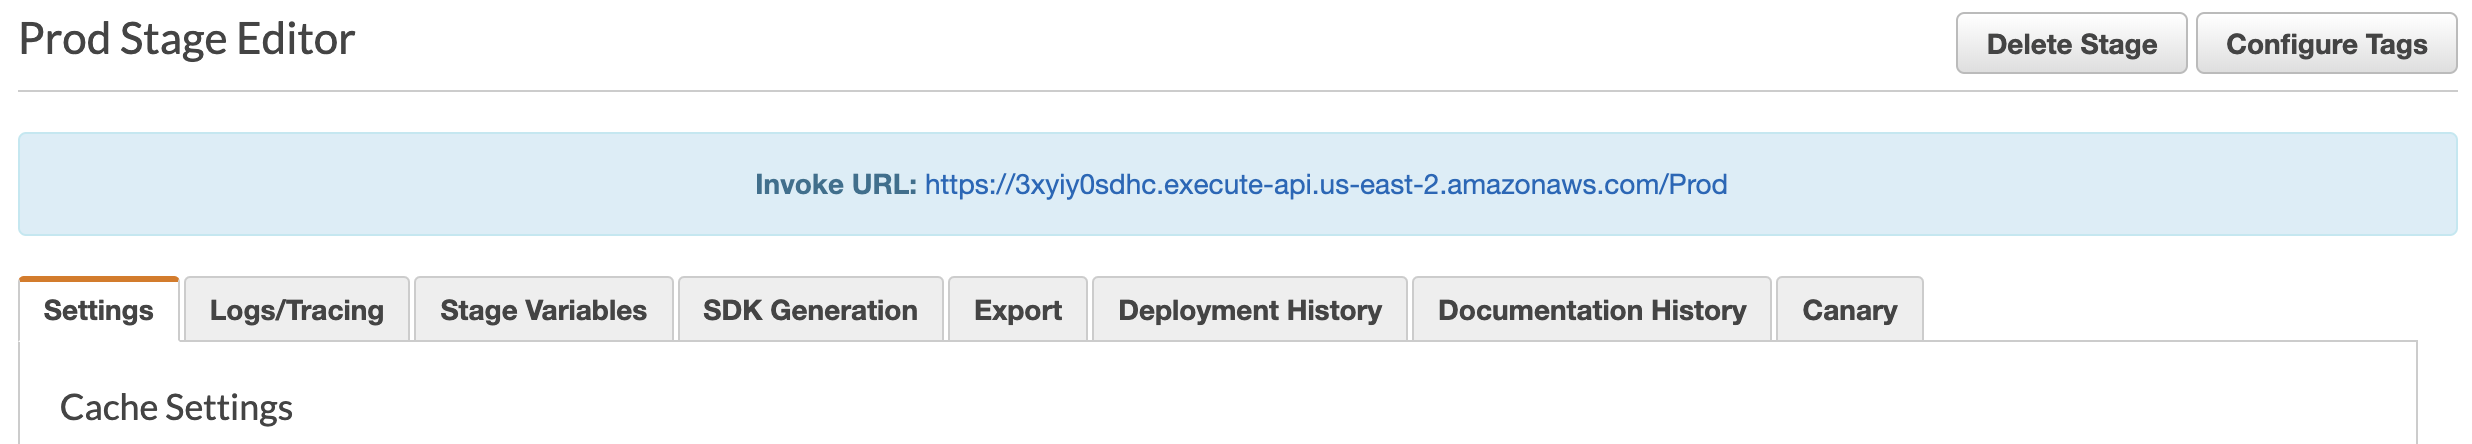

This url is now an API that can be used by anyone with permission from anywhere to invoke your lambda and thus call the model endpoint.

You can use [Postman](https://www.postman.com/) to make POST API calls or there are multiple ways to do so like curl etc. Below is the example to hit this API using Postman.

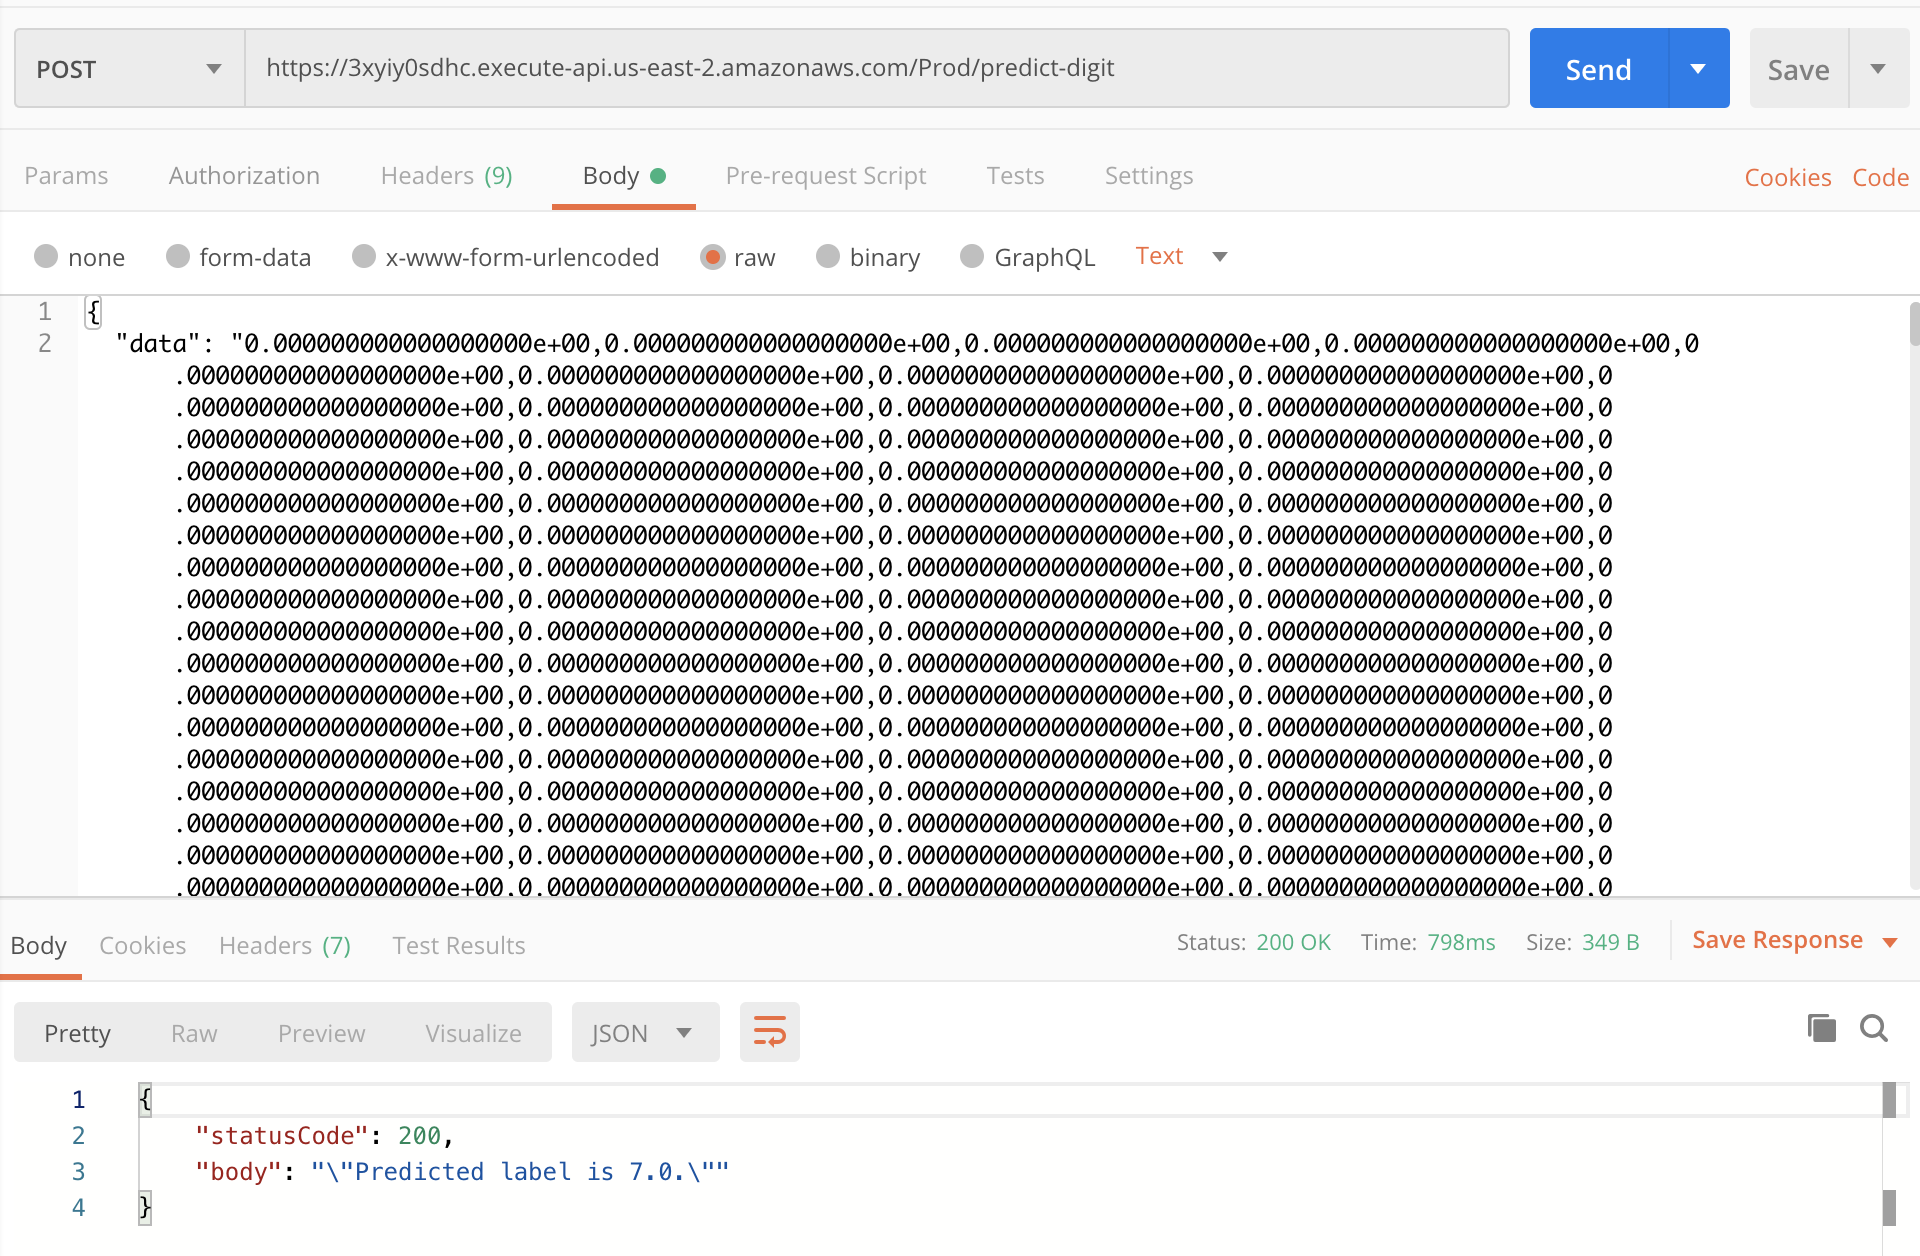

Yayyy, we did it. It’s done and it’s out there.

Just show off to your friends and ask them to hit your newly ML based API.

## Summary & Conclusion!

In this article, we talked about creating a simple Machine Learning model using various AWS tools and make it available to the end user. Most of the students working on projects focus on the working of their Machine Learning code and do not give focus on proper creation of the entire stack and flow that can easily manage their project and make it available to end users like a new product. This article will help them to deliver their project like a software.